In [96]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.exceptions import FitFailedWarning
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from scripts.data_processing import *
from scripts.data_training import *

# Suppress warnings
import warnings
warnings.filterwarnings('ignore', category=FitFailedWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
# Importing data
raw_df = pd.read_csv('data/raw/bank-full.csv', delimiter=';')
raw_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### Exploratory Data Analysis

In [3]:
# Describe the data type and the number of invalid values in columns
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


**Observations:**  
- The dataset contains `45,211` records (`customers`) and `17` columns (`attributes`).  
- There are 7 numerical columns `(int64)`, such as age (`age`) or balance (`balance`).  
- 10 columns have the `object` type, which means these attributes contain categorical data, such as job type (`job`), marital status (`marital`), whether the client has a personal loan (`loan`), etc.  
- The target variable for classification is `y`, which is an `object` type column. It indicates whether the customer subscribed to a term deposit.  
- There are no missing values in any columns (all columns have `45,211` non-null values).  


In [4]:
# Select numerical columns
int_columns = raw_df.select_dtypes(include='int64').columns
int_columns

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')

In [5]:
# Select categorical columns
obj_columns = raw_df.select_dtypes(include='object').columns
obj_columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome', 'y'],
      dtype='object')

**Observations:**  
- `age`, `balance`, `day`, `duration`, `campaign`, `pdays`, `previous` — quantitative variables that can be used for quantitative analysis of customer behavior.  
- `job`, `marital`, `education`, `default`, `housing`, `loan`, `contact` — categorical variables that characterize the customer profile (e.g., social status, education level, credit status).  
- Additionally, `day` and `month` — the date of the last contact with the customer, which may be important for identifying seasonal or temporal trends.  

#### Detailed analysis of the columns

#### Analysis Of Column `AGE`

Analyzing numeric column: age

Data type: int64
Number of unique values: 77


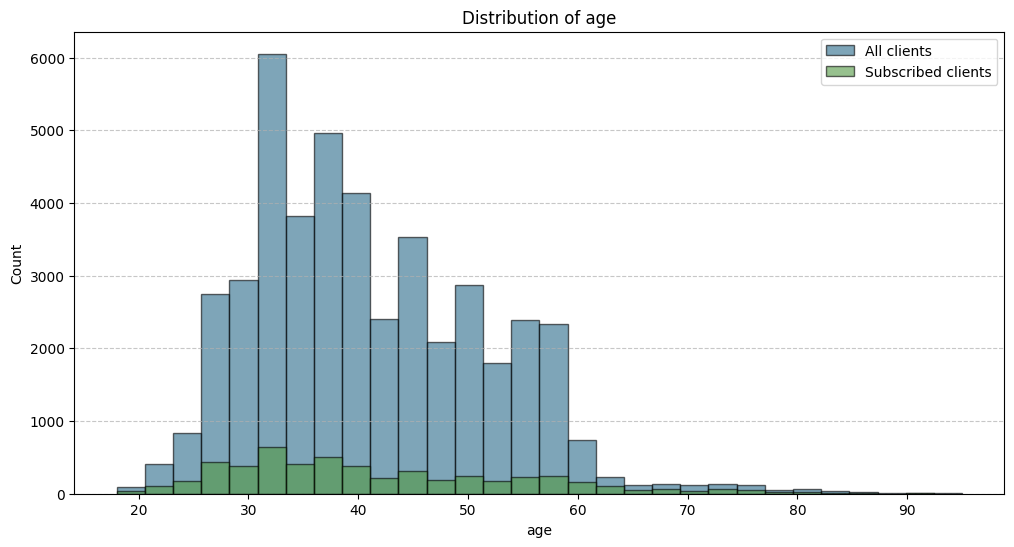

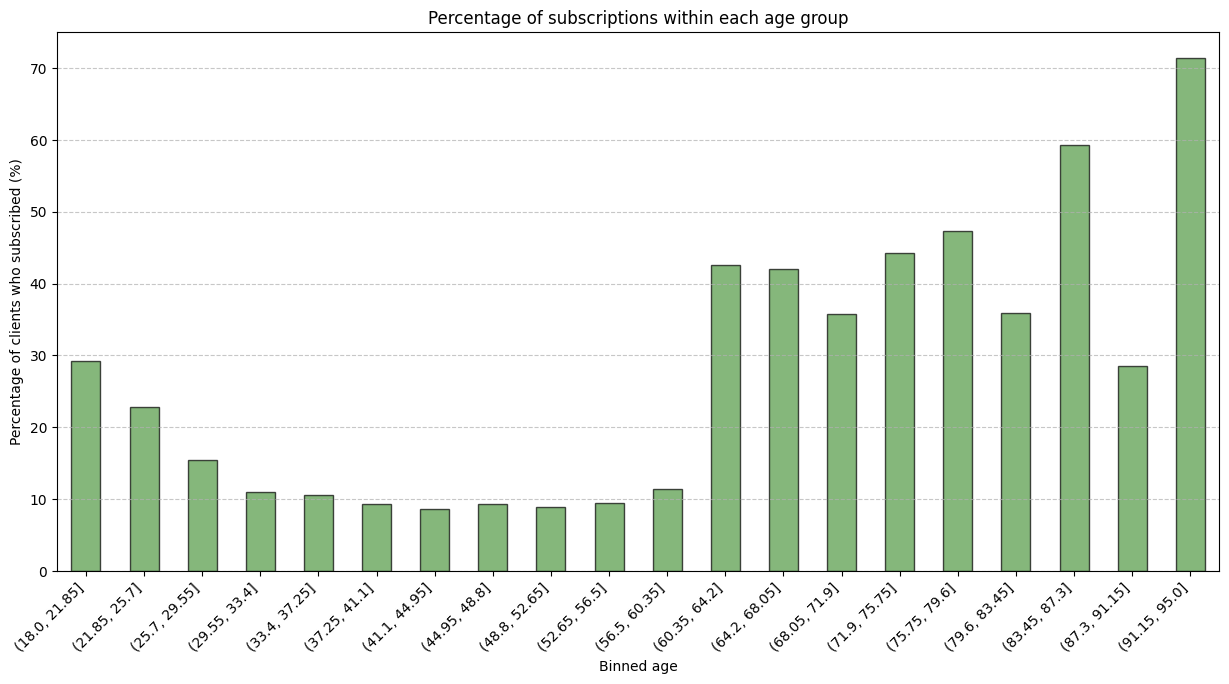

In [6]:
# Call the function to analyze the 'age' column
analyze_column(raw_df, 'age')

**Analysis of Age Distribution Chart:**  
- **Peak Distribution:** The majority of customers (including those who subscribed to a term deposit) are around `30-40` years old.  
- Age below `20` and above `60` has significantly fewer customers, indicating low activity of these age groups in using term deposits.

This analysis may suggest that, for better targeting of marketing campaigns, more attention should be paid to customers aged 30 to 50, as they constitute the primary part of the customer base.

**Analysis of Percentage Distribution Chart:**  
- **Younger Clients (`18-25` years):**  
  The highest percentage of deposit subscription is observed among customers aged `18` years (over `60%`).  
  After this, the percentage drops sharply but remains in the range of `15-30%` for age groups from `20 to 25` years.

- **Middle Age (`26-60` years):**  
  In the age groups from `26` to approximately `60` years, the subscription percentage is relatively stable, holding around `10-25%`.  
  This part of the chart shows that middle-aged customers have a lower interest in signing up for deposits compared to younger and older customers.

- **Older Clients (over `60` years):**  
  Starting from `60` years and above, there is a gradual increase in the percentage of deposit subscriptions.  
  Notably, customers aged over `90` show a resurgence in the subscription rate, reaching up to around `100%`. This could be due to older clients often having savings they are willing to invest in deposits.

**Fluctuations on the Chart:**  
The subscription percentages for age groups appear irregular and vary, which may indicate an unstable number of customers across different age categories. For example, in age groups over `90` years, some values reach 100%, possibly reflecting a small sample size in these categories.

**Overall Conclusion:**  
- Younger customers and older people (especially those over `60` years) are more likely to sign up for term deposits than middle-aged customers.  
- A large proportion of elderly customers subscribe to deposits, which may indicate their greater financial stability and willingness to earn income from their savings.  
- The uneven nature of the chart may also result from an uneven distribution of customers by age, requiring a more detailed analysis.  

#### Analysis Of Column `Job`

Analyzing categorical column: job

Data type: object
Number of unique values: 12

Unique values:
['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']

Value counts:
job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: count, dtype: int64


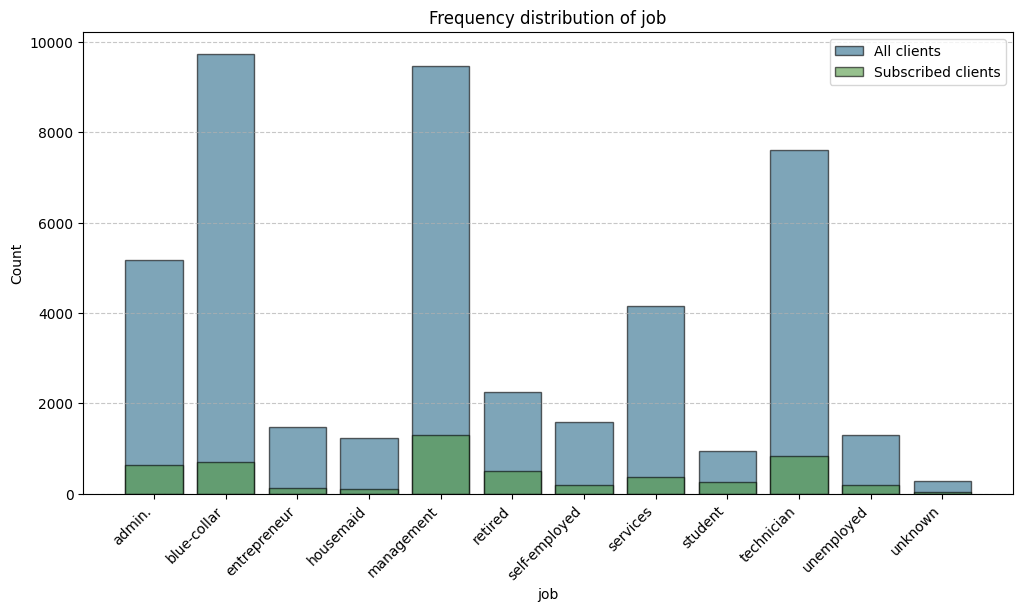

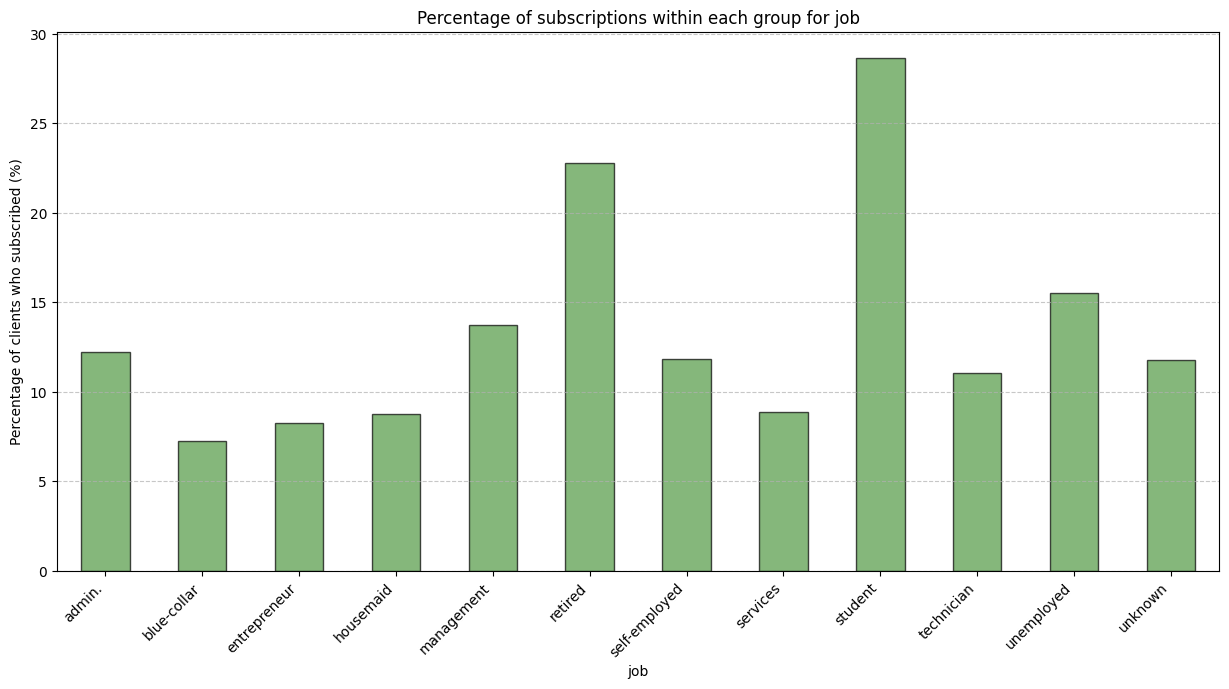

In [7]:
# Call the function to analyze the 'job' column
analyze_column(raw_df, 'job')

**Analysis of Professional Groups:**  
- **`Management`:**  
  The highest number of sign-ups among those who subscribed to a term deposit are clients working in the "management" field.  
  This indicates that people with stable incomes are more likely to subscribe to deposits. Managers typically have a higher income level, allowing them to invest in deposits, while retirees might be looking for safe places for their savings.

- **`Blue-Collar`:**  
  The "blue-collar" profession (manual labor) has the largest share among those who did not subscribe to a term deposit.  
  This may suggest that such clients either have lower purchasing power or are less interested in deposits due to their financial needs.

- **`Students`:**  
  Students have a higher share among those who subscribed to a deposit compared to many other categories.

- **`Self-Employed` and `Entrepreneurs`:**  
  Professions like "self-employed" and "entrepreneur" have a smaller share among those who signed up for a term deposit.  
  This could be due to unstable income or a preference to invest money in business rather than in savings accounts.

- **`Technician` and `Admin`:**  
  Professions such as "technician" and "admin" are present in both groups, but among those who subscribed to a deposit, their numbers are noticeably lower than managers.

**Interest Analysis:**  

- **`Highest Interest`:**  
  Students have the highest percentage of signed deposits — around `28.7%`.  
  This could indicate that students want to set aside money for future security, or they have some access to finances they can save.  
  Retirees (`retired`) also have a high share — approximately `22.8%`, indicating that retirees are looking for safe options to preserve their savings.

- **`Moderate Interest`:**  
  The unemployed (`unemployed`) have a share of `15.5%`, which is quite surprising, as one might assume that such clients have limited financial capacity.  
  Perhaps some of them are planning to use their savings for a long-term plan.  
  Professions such as `management` and `admin` also show a certain level of signed deposits (`13.8%` and `12.2%`, respectively).

- **`Lowest Interest`:**  
  Manual labor (`blue-collar`) has the lowest percentage of signed deposits — `7.3%`.  
  This may indicate lower purchasing power or limited savings opportunities.  
  `entrepreneur` and `housemaid` also have a low level of signed deposits (`8.3%` and `8.8%`, respectively), which could be related to unstable income.

**Conclusion:**  Overall, clients in professions that involve stable income and savings are more likely to subscribe to term deposits.  

#### Analysis Of Column `marital`

Analyzing categorical column: marital

Data type: object
Number of unique values: 3

Unique values:
['married' 'single' 'divorced']

Value counts:
marital
married     27214
single      12790
divorced     5207
Name: count, dtype: int64


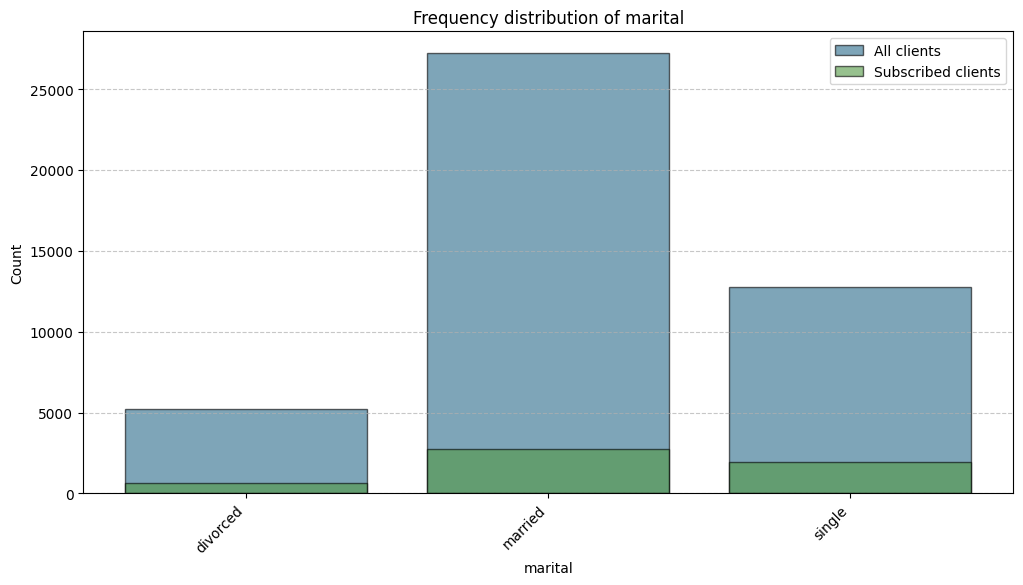

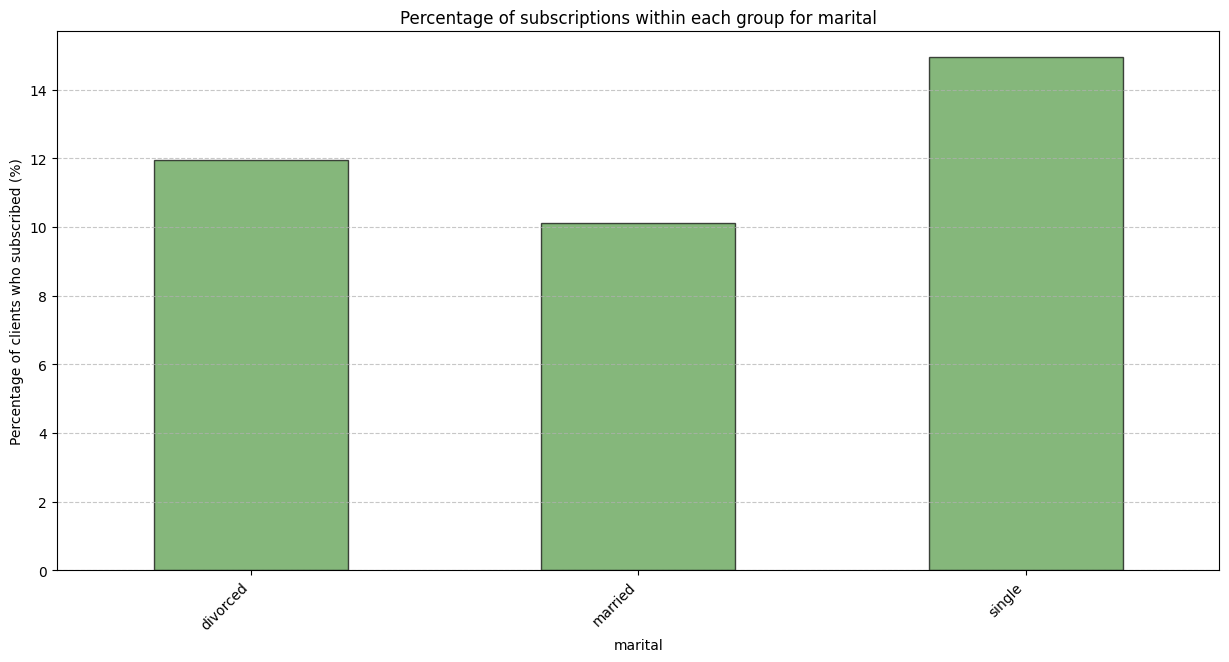

In [8]:
# Call the function to analyze the 'marital' column
analyze_column(raw_df, 'marital')

**Analysis:**  

- From the first chart, it is clear that the number of married clients significantly exceeds the number of single and divorced clients. However, the proportion of those who subscribed to a deposit is visually lower, which is confirmed by the following chart.

- The highest share belongs to the `single` group (about `14%`). Next are `divorced` clients with a share of approximately `12%`, and the smallest share is held by `married` clients — around `10%`.

**Conclusions:**  
- Despite married clients constituting the largest part of the customer base, they have the lowest likelihood of subscribing to a term deposit.  
- Clients who are single have the highest percentage of deposit sign-ups.  

#### Analysis Of Column `education`

Analyzing categorical column: education

Data type: object
Number of unique values: 4

Unique values:
['tertiary' 'secondary' 'unknown' 'primary']

Value counts:
education
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: count, dtype: int64


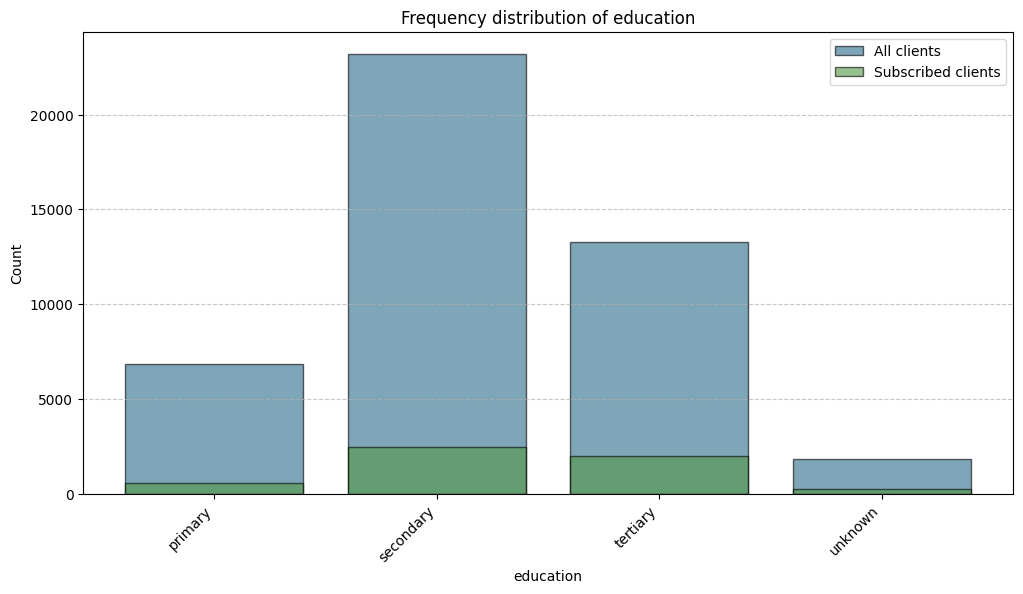

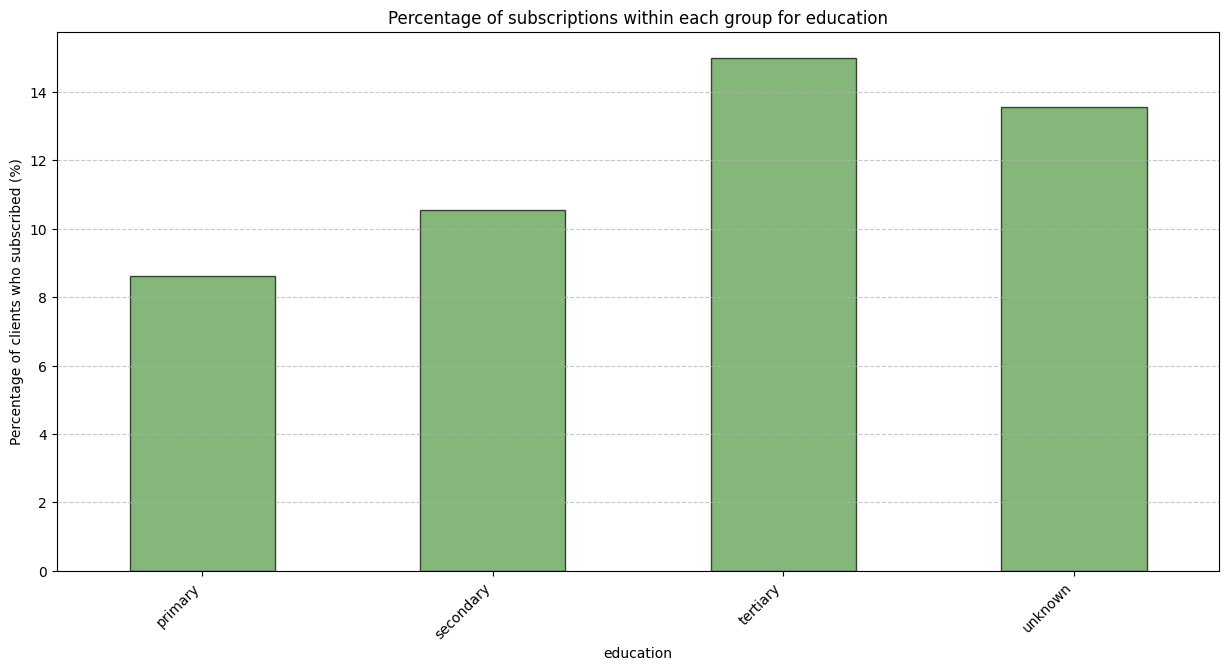

In [9]:
# Call the function to analyze the 'education' column
analyze_column(raw_df, 'education')

**Analysis:**  

- The largest share of clients has secondary education (`secondary`), followed by higher education (`tertiary`), then clients with primary education (`primary`), and the smallest share consists of clients with an undefined education level (`unknown`).  
- It is evident that clients with secondary education make up the largest group, but their relative share of term deposit subscriptions is smaller compared to groups with higher education.  
- The highest proportion of clients who subscribed to a deposit is in the group with higher education (`tertiary`) — around `13-14%`. Next are clients with an unknown education level (`unknown`) and secondary education (`secondary`), approximately `10-12%`. The lowest share of subscribers belongs to clients with primary education (`primary`).  

**Conclusions:**  
- Clients with higher education (`tertiary`) have the highest likelihood of subscribing to a term deposit, which may indicate that the education level is linked to financial awareness and willingness to invest in banking products.  
- The group of clients with secondary education (`secondary`) is the largest, but their share of deposit subscribers is moderate, suggesting that additional educational or informational campaigns may be needed to increase their engagement.  

**Recommendations:**  
- The bank should focus its efforts on attracting clients with higher education (`tertiary`), as this group shows the most interest in deposits, and also find ways to increase the engagement of clients with secondary education (`secondary`).  

#### Analysis Of Column `default`

Analyzing categorical column: default

Data type: object
Number of unique values: 2

Unique values:
['no' 'yes']

Value counts:
default
no     44396
yes      815
Name: count, dtype: int64


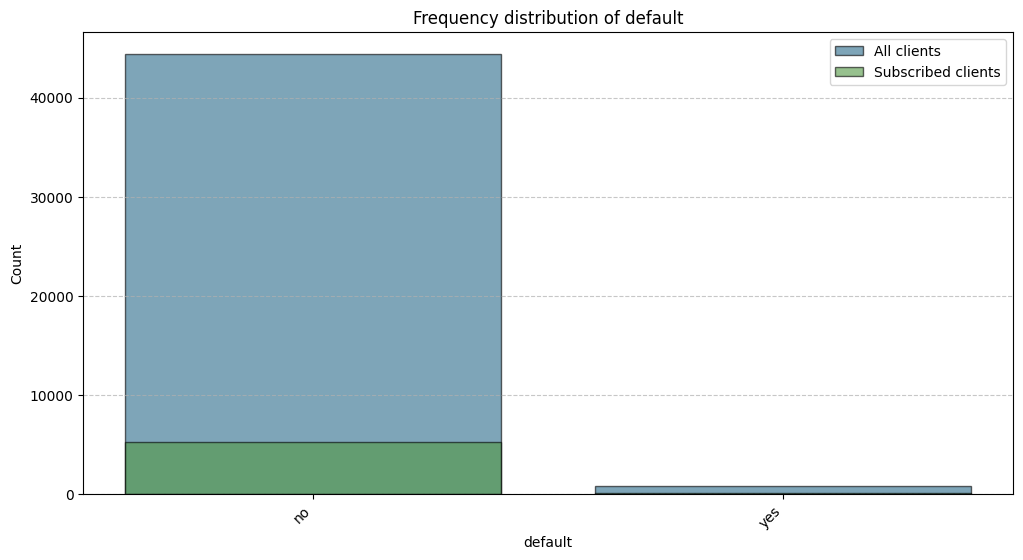

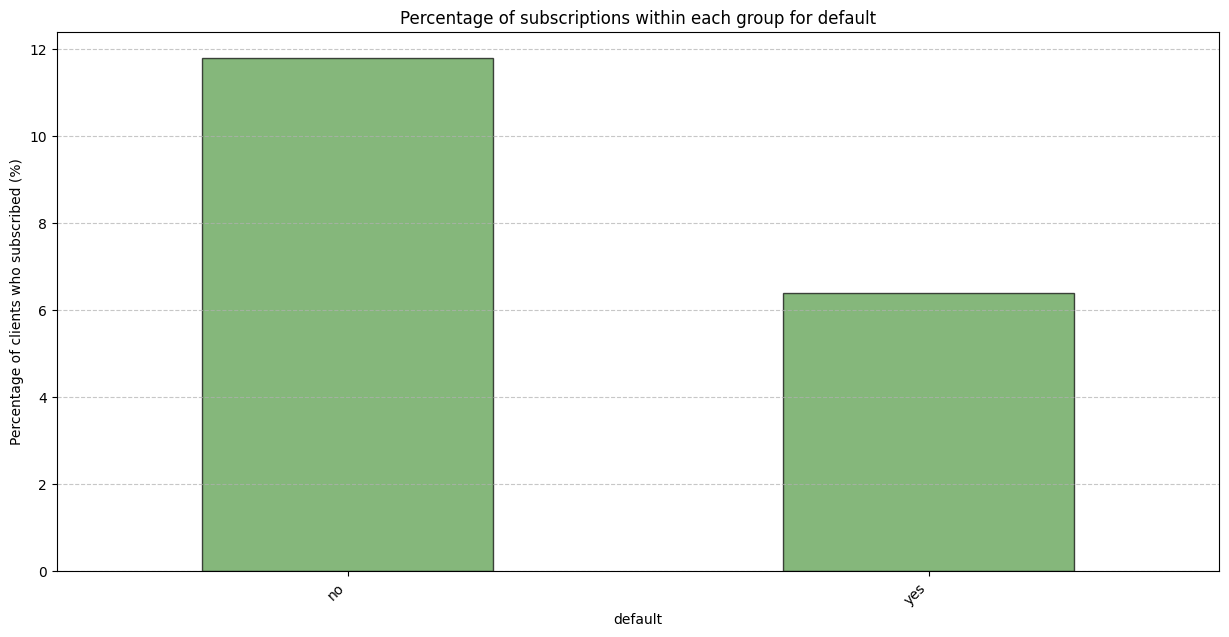

In [10]:
# Call the function to analyze the 'default' column
analyze_column(raw_df, 'default')

**Analysis:**  

- The vast majority of clients do not have default loans (`no`), which is visually represented by a much larger blue bar. A very small proportion of clients have loans in default (`yes`).  
- Clients without default loans (`no`) are significantly more likely to subscribe to term deposits (around `11-12%`) compared to clients with default loans (`yes`) (around `5-6%`).  

**Conclusions:**  
- Clients without default loans have a significantly higher likelihood of subscribing to a term deposit.  

#### Analysis Of Column `balance`

Analyzing numeric column: balance

Data type: int64
Number of unique values: 7168


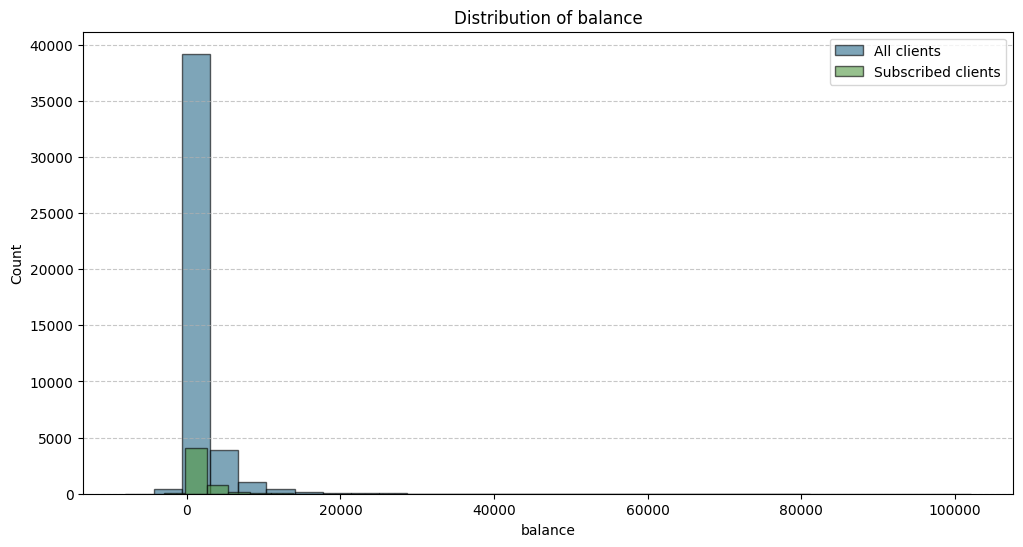

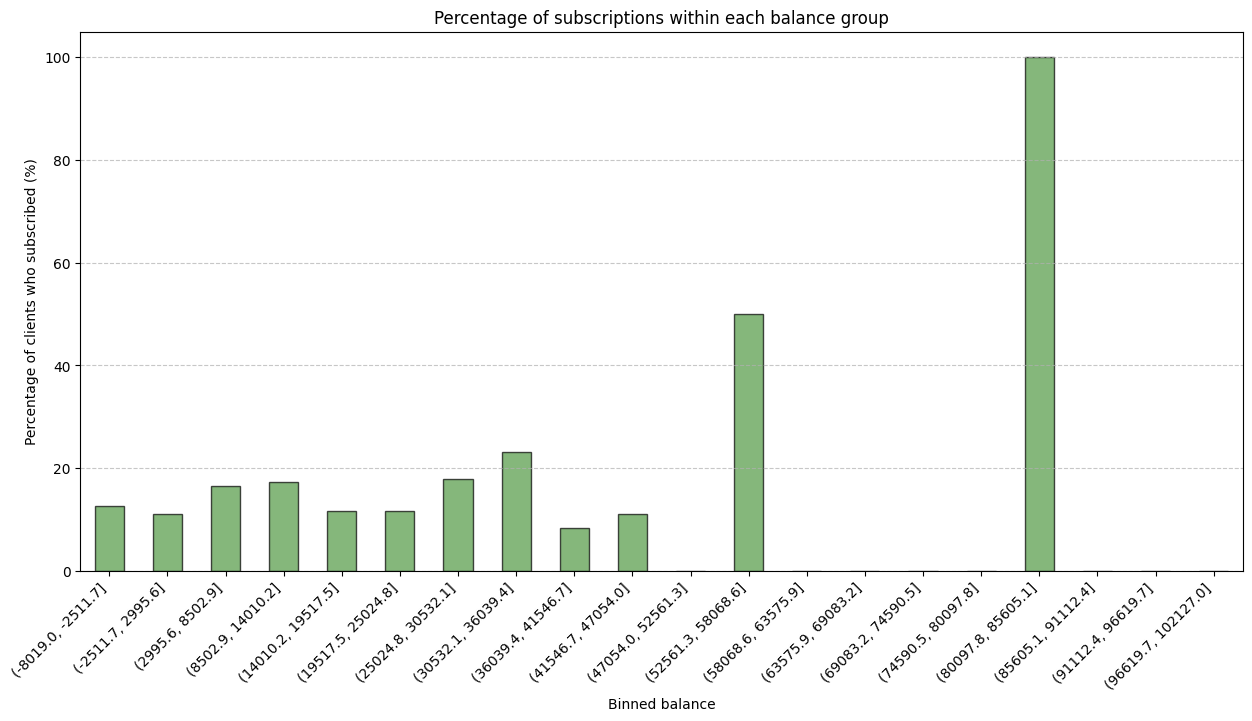

In [11]:
# Call the function to analyze the 'balance' column
analyze_column(raw_df, 'balance')

**Analysis:**  

- The majority of clients have a balance close to zero.  
- The bars for clients with a significant balance (e.g., over `20,000 euros`) are very low.  
- A substantial number of clients have a low average balance, which may indicate that clients with high account balances are rare.  
- For clients with a higher balance (especially in the `50,000 - 86,000 euros` range), the likelihood of subscribing to a term deposit increases significantly and even reaches 100%. This could suggest that clients with higher balances are more interested in opening deposits.

**Conclusions:**  
- Clients with a high average annual balance have a significantly higher likelihood of subscribing to a term deposit.  

#### Analysis Of Column `housing`

Analyzing categorical column: housing

Data type: object
Number of unique values: 2

Unique values:
['yes' 'no']

Value counts:
housing
yes    25130
no     20081
Name: count, dtype: int64


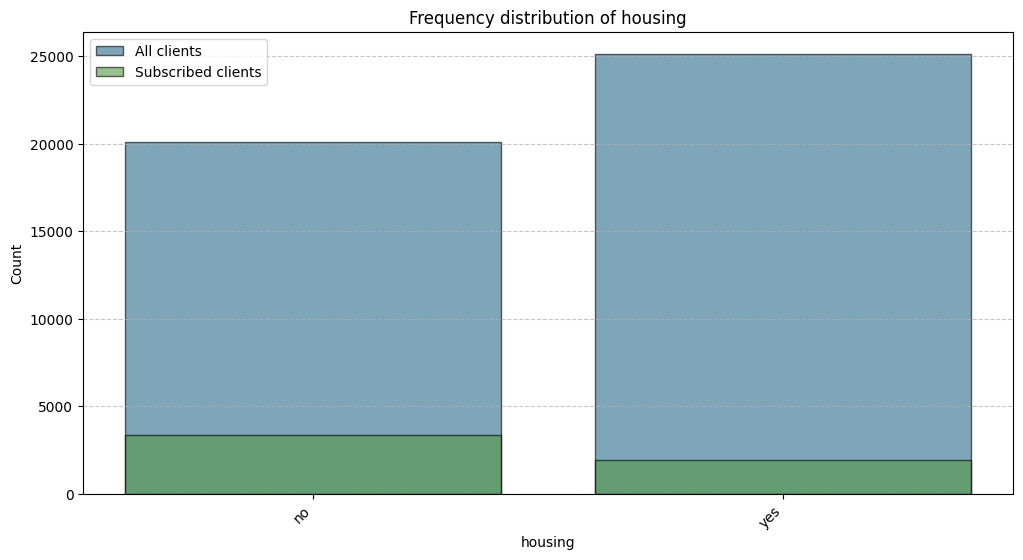

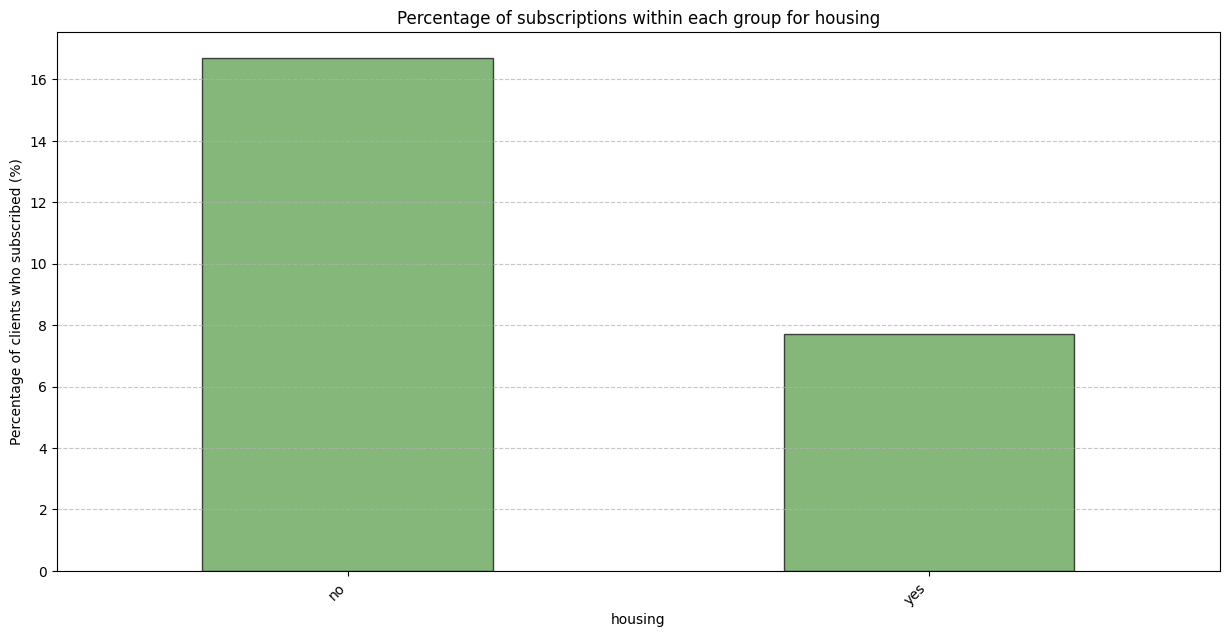

In [12]:
# Call the function to analyze the 'housing' column
analyze_column(raw_df, 'housing')

**Analysis:**  

- The number of clients with a housing loan (`yes`) slightly exceeds those without (`no`).  
- Clients without a housing loan (`no`) have a significantly higher likelihood of subscribing to a term deposit — around `16%`. In contrast, clients with a housing loan (`yes`) have a lower likelihood of subscribing — approximately `8%`.  

**Conclusions:**  
- Clients without a housing loan are more likely to subscribe to a term deposit. This could indicate that having a housing loan reduces a client's ability to open a deposit, possibly due to the additional financial burden.  

**Recommendations:**  
- The bank should focus its marketing campaigns on clients without a housing loan, as they have a higher chance of subscribing to a term deposit. Meanwhile, for clients with a housing loan, special offers could be developed to make term deposits more attractive, even in the presence of additional credit obligations.  

#### Analysis Of Column `loan`

Analyzing categorical column: loan

Data type: object
Number of unique values: 2

Unique values:
['no' 'yes']

Value counts:
loan
no     37967
yes     7244
Name: count, dtype: int64


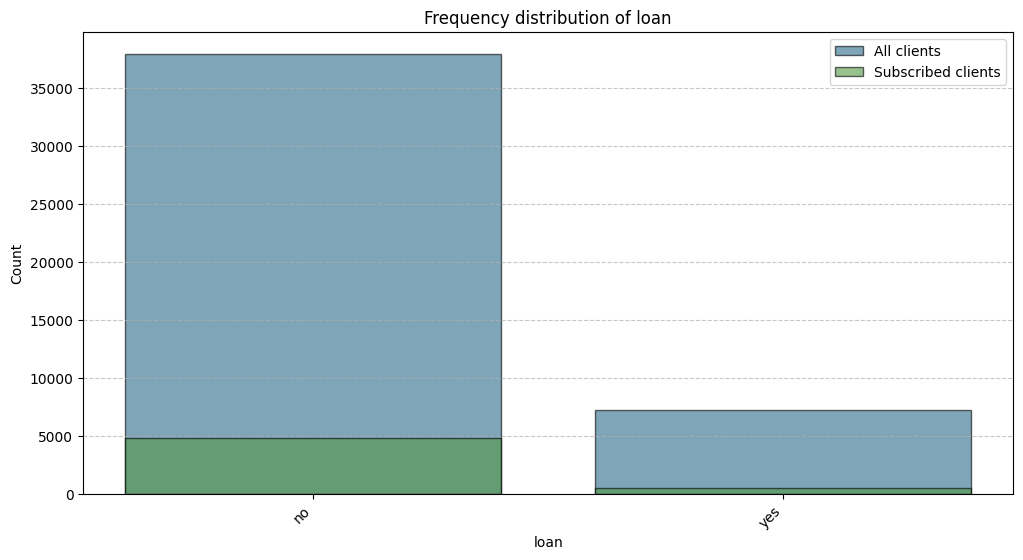

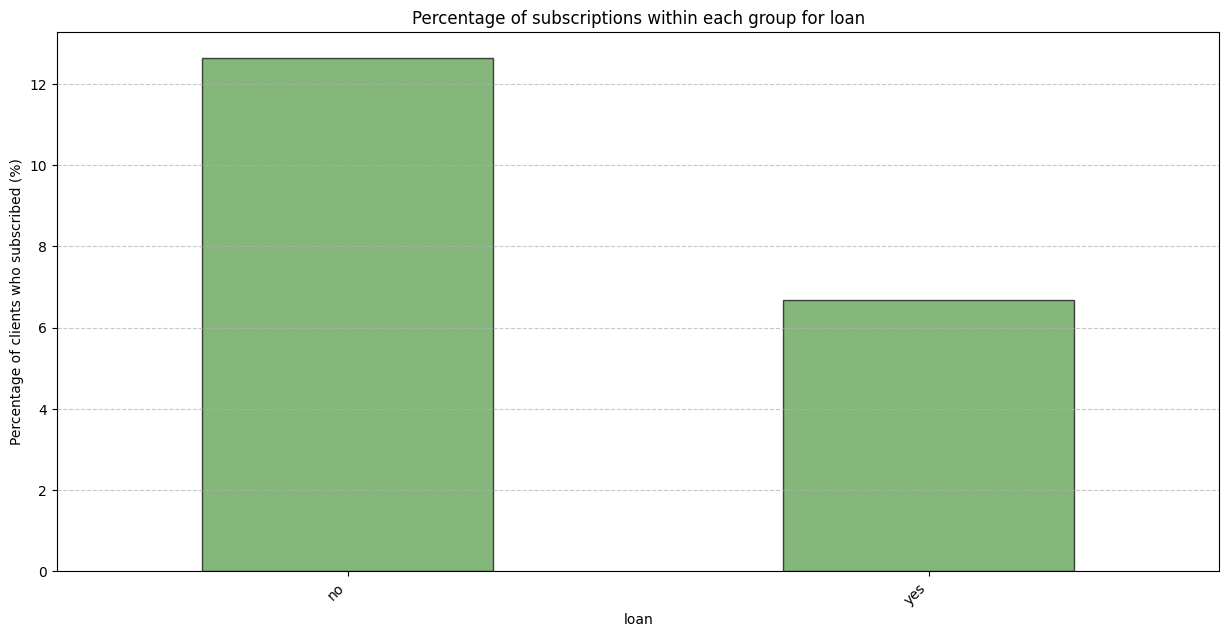

In [13]:
# Call the function to analyze the 'loan' column
analyze_column(raw_df, 'loan')

**Analysis:**  

- The majority of clients do not have a personal loan (`no`).  
- A significantly smaller proportion of clients have a personal loan (`yes`).  
- Clients without a personal loan are much more likely to subscribe to a term deposit — approximately `12%`.  
- Clients with a personal loan have a significantly lower likelihood of subscribing to a deposit, around `6%`.  

**Conclusions:**  
- Clients without a personal loan are more likely to subscribe to a term deposit. This may indicate that the absence of credit obligations increases a client's ability to invest in a deposit, possibly due to a lower financial burden.  

**Recommendations:**  
- The bank should focus its marketing campaigns on clients without personal loans, as they show a greater interest in term deposits. At the same time, clients with credit obligations could be offered special conditions to make deposits more appealing despite their existing financial commitments.  

#### Analysis Of Column `contact`

Analyzing categorical column: contact

Data type: object
Number of unique values: 3

Unique values:
['unknown' 'cellular' 'telephone']

Value counts:
contact
cellular     29285
unknown      13020
telephone     2906
Name: count, dtype: int64


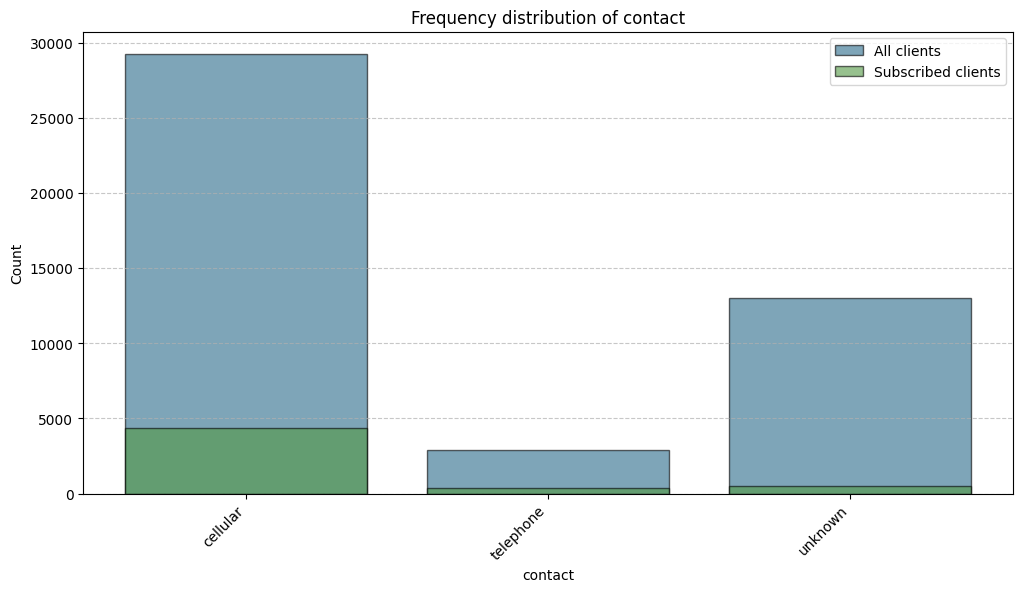

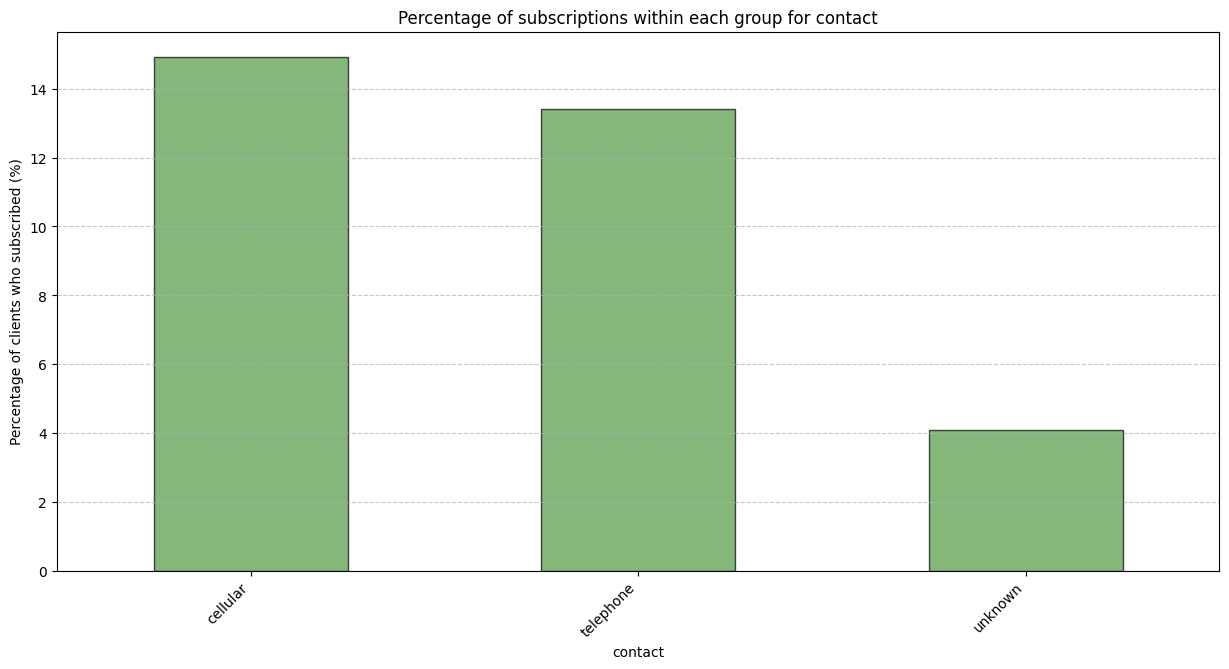

In [14]:
# Call the function to analyze the 'contact' column
analyze_column(raw_df, 'contact')

**Analysis:**  

- Most clients were contacted via mobile communication (`cellular`), the second-largest group is clients with an unknown type of communication (`unknown`), and the smallest group consists of those contacted via landline (`telephone`).  
- The highest likelihood of subscribing to a deposit is seen in clients contacted via mobile communication (`cellular`) — around `14%`.  
- It is also noticeable that clients contacted via landline (`telephone`) have a slightly lower likelihood of subscribing to a deposit — around `12%`.  
- The least effective communication channel is `unknown`, where the share of subscribers is the smallest.  

**Conclusions:**  
- Mobile communication (`cellular`) is the most effective communication channel for attracting clients to sign up for term deposits. The bank should focus on this type of communication to improve the efficiency of its marketing campaigns.  
- Contacting via landline can also be effective, but it has a slightly lower success rate compared to mobile communication.  

**Recommendations:**  
- It is necessary to work on increasing the effectiveness of communication for clients with an undefined type of communication or try to obtain more information about them to apply more targeted communication methods.  

#### Analysis Of Column `day`

Analyzing numeric column: day

Data type: int64
Number of unique values: 31


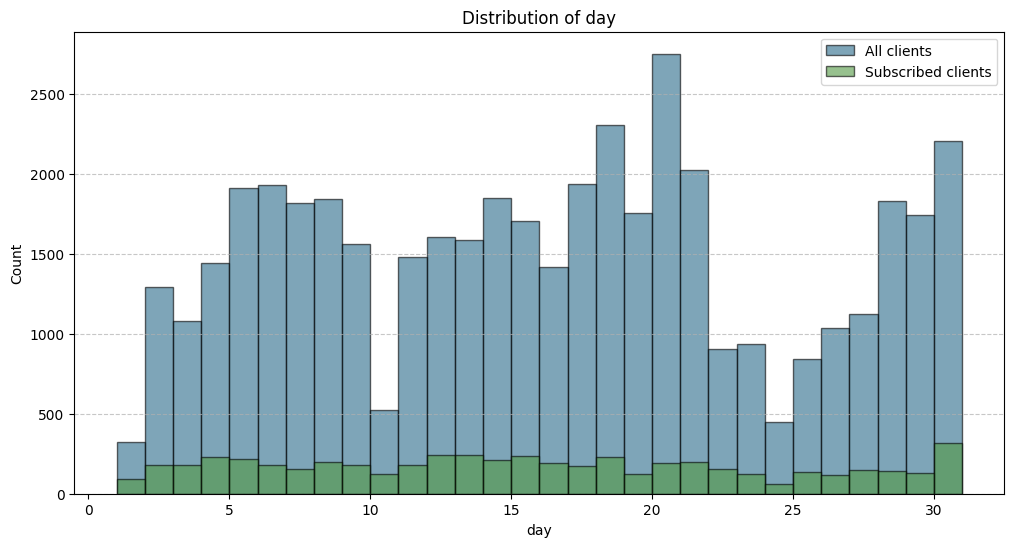

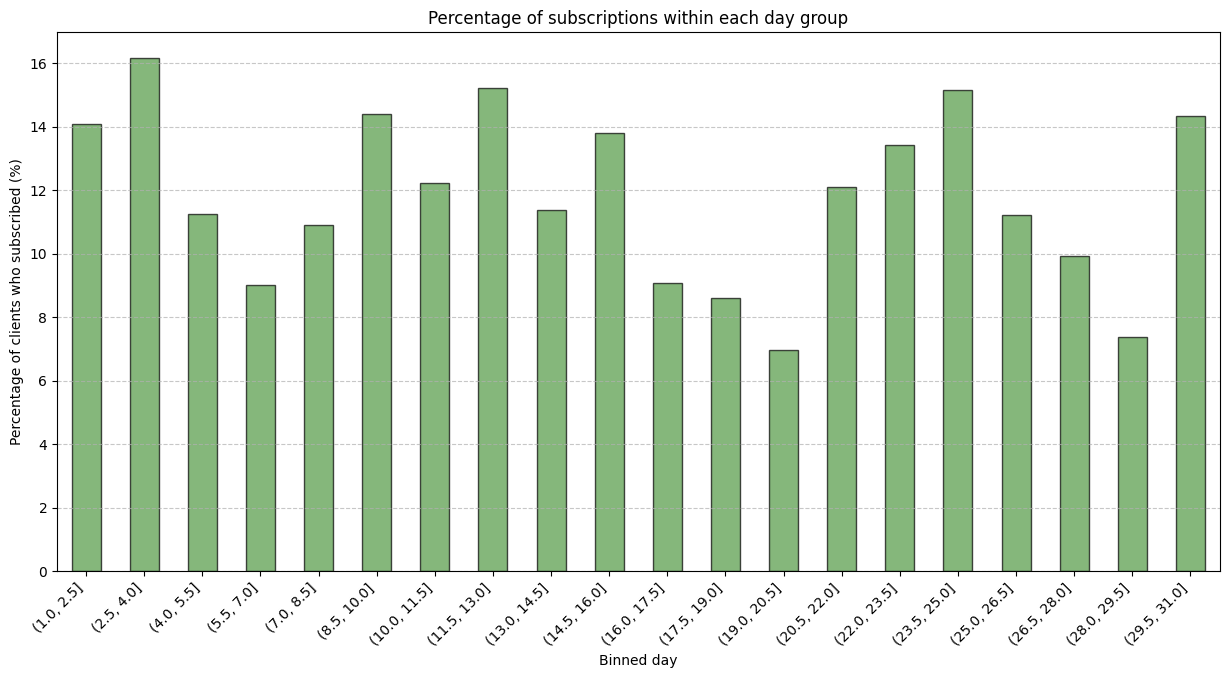

In [15]:
# Call the function to analyze the 'day' column
analyze_column(raw_df, 'day')

**Analysis:**  

- Contacts with clients are evenly distributed throughout the month, but there are certain peaks around the 20th and at the end of the month.  
- The highest percentage of term deposit sign-ups is observed in the first 10 days of the month (around `12%`), indicating greater effectiveness of contacts at the beginning of the month.  
- In the middle and late parts of the month, the subscription rates are almost the same but slightly lower than in the early part of the month.  


#### Analysis Of Column `month`

Analyzing categorical column: month

Data type: object
Number of unique values: 12

Unique values:
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']

Value counts:
month
may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: count, dtype: int64


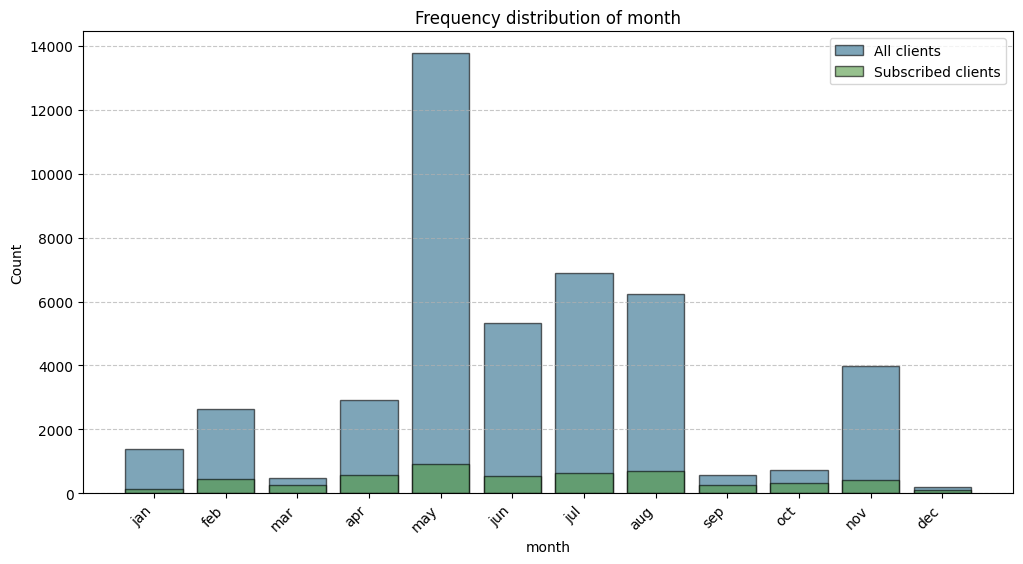

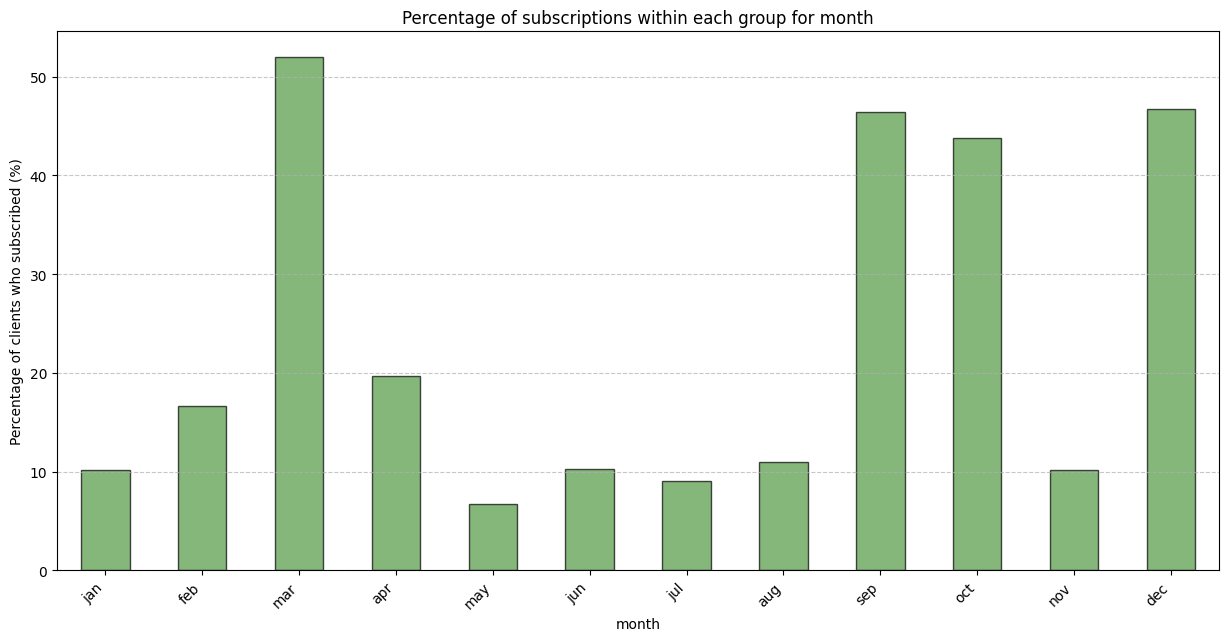

In [16]:
# Call the function to analyze the 'month' column
analyze_column(raw_df, 'month')

**Analysis:**  

- May had the highest number of clients, but a significant portion of them did not subscribe.  
- The highest subscription percentage was observed in March, September, October, and December.  



#### Analysis Of Column `duration`

Analyzing numeric column: duration

Data type: int64
Number of unique values: 1573


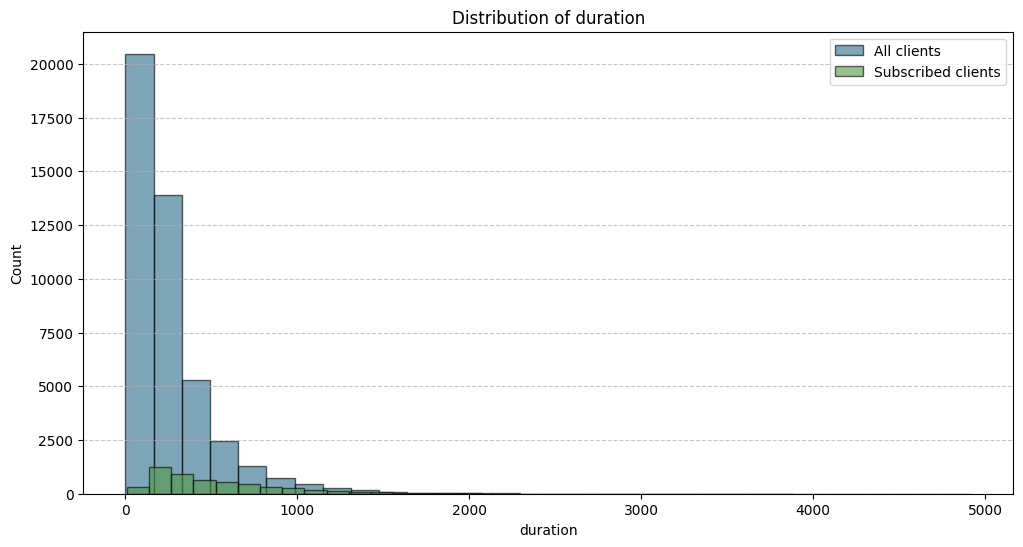

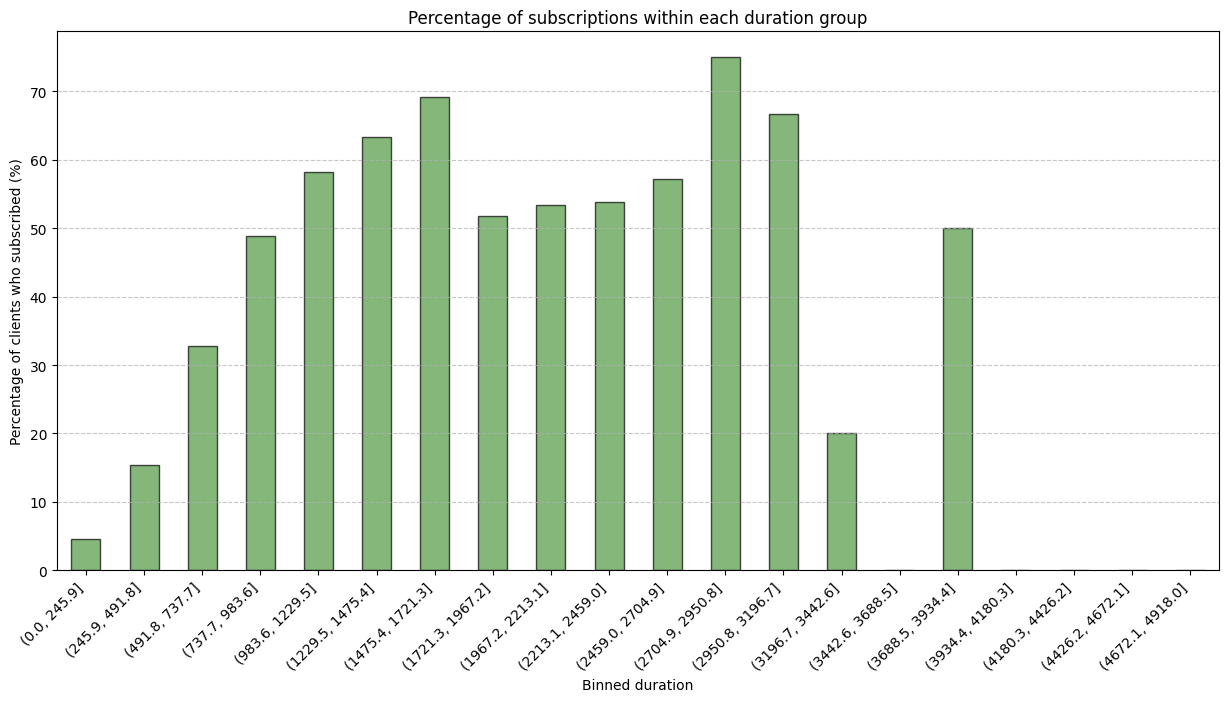

In [17]:
# Call the function to analyze the 'duration' column
analyze_column(raw_df, 'duration')

**Analysis:**  

- The chart shows that most contacts were very short (`from 0 to 500 seconds`).  
- The highest subscription rate was observed in groups with a duration of `between 950 and 1800` seconds, as well as in groups with a duration `between 2700 and 3200` seconds.  

**Conclusions:**  
- The second chart indicates that the longer the conversation, the higher the chances that the client will subscribe. This could suggest that longer interactions provide an opportunity to better persuade the client.  


#### Analysis Of Column `campaign`

Analyzing numeric column: campaign

Data type: int64
Number of unique values: 48


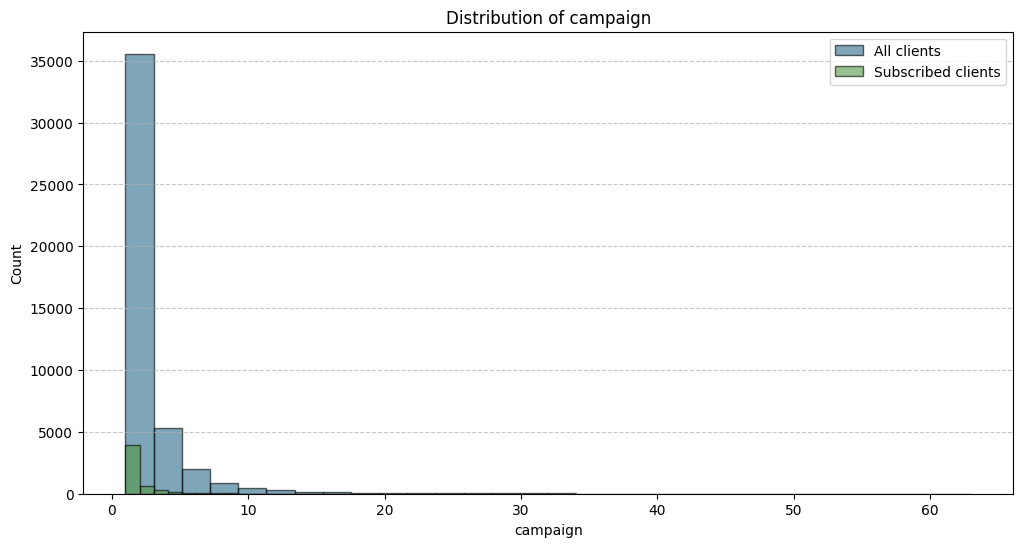

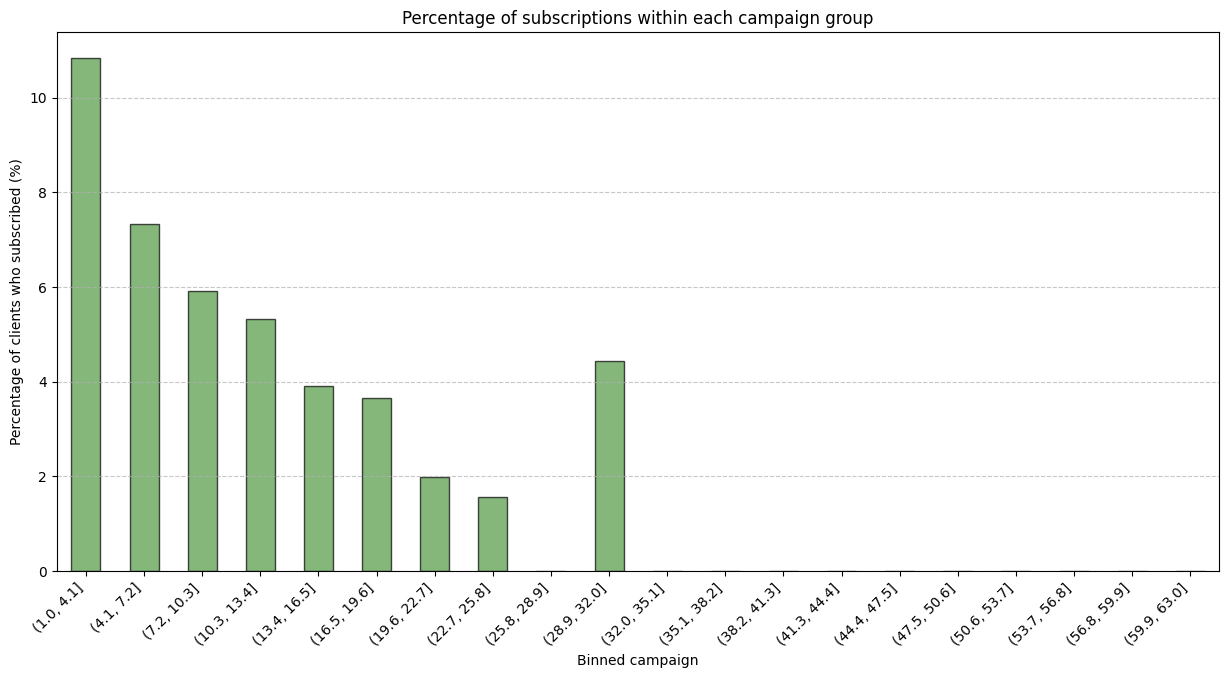

In [18]:
# Call the function to analyze the 'campaign' column
analyze_column(raw_df, 'campaign')

**Analysis:**  

- The vast majority of clients were contacted only a few times (`from 1 to 3 times`).  
- Most clients were contacted less than `5 times`.  
- It is evident that the number of clients who subscribed gradually decreases as the number of contacts increases.  
- The highest subscription rate is among those clients who were contacted `1 to 3 times`.  

**Conclusions:**  
- This may indicate that overly frequent contacts could be perceived as intrusive, reducing the success of subscriptions.  


#### Analysis Of Column `pdays`

Analyzing numeric column: pdays

Data type: int64
Number of unique values: 559


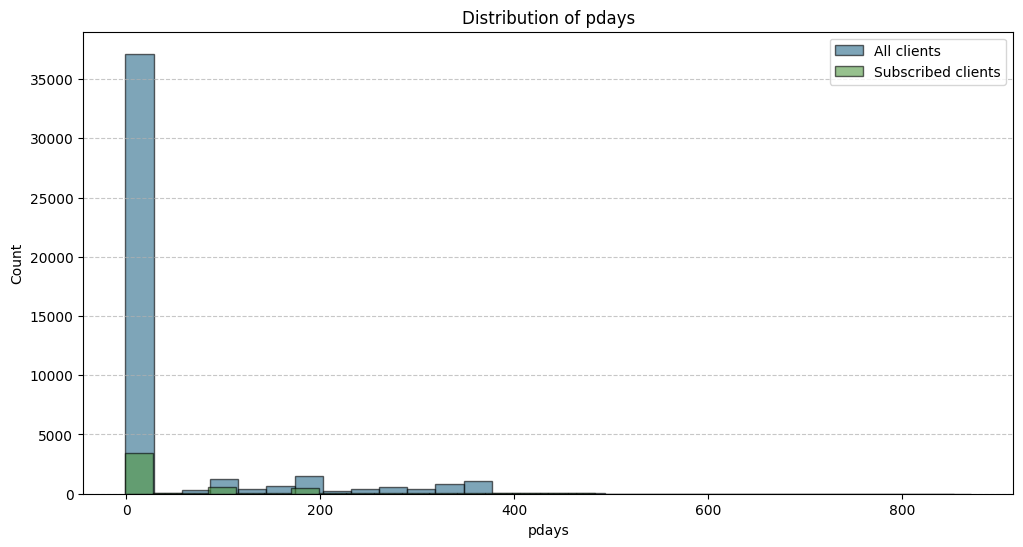

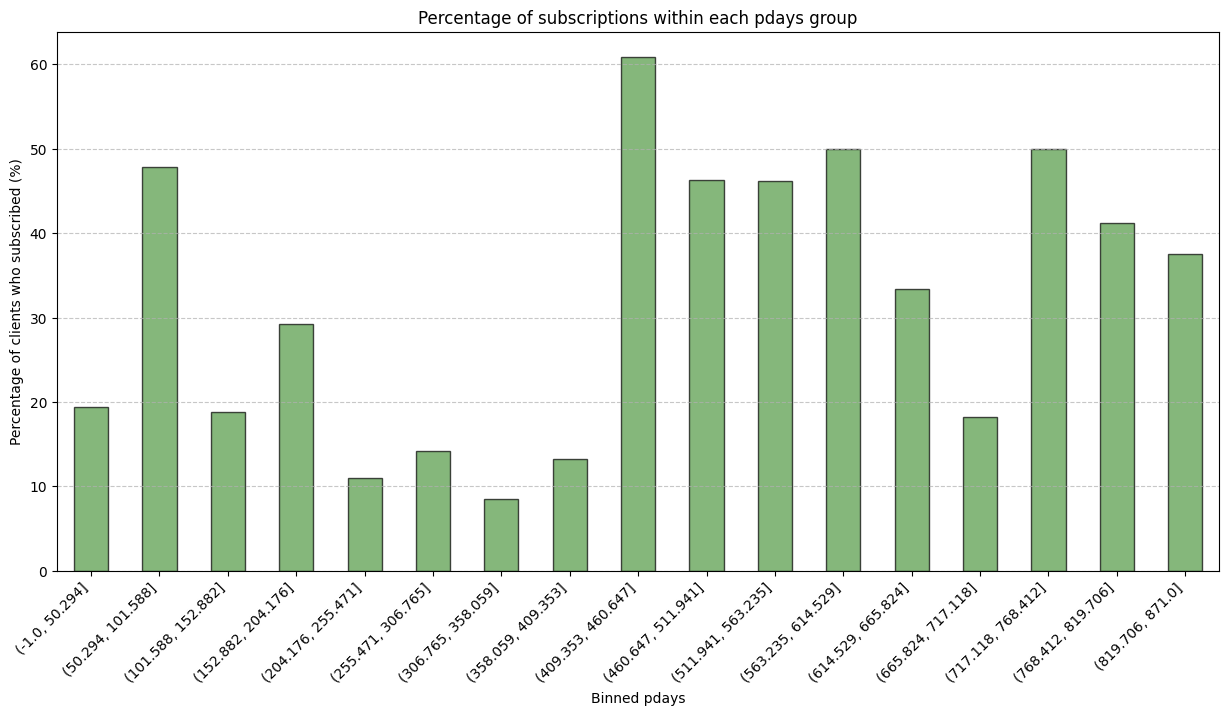

In [19]:
# Call the function to analyze the 'pdays' column
analyze_column(raw_df, 'pdays')

**Analysis:**  

- Most clients have a value of `-1`, indicating that they had no previous contact.  
- The number of subscribed clients with a value of `-1` is also quite high.  
- The highest subscription rate is observed among clients who were contacted after a time interval between `50 and 100 days` since the previous contact.  

**Conclusions:**  
- Overall, the trend suggests that after a certain period (e.g., after `50 days`), the probability of a client subscribing increases again, which may indicate renewed interest in the service after a prolonged break. These charts indicate that clients who have not been contacted for a long time (or never contacted before) have a high chance of subscribing. This information can be used to determine the optimal timing for follow-up contact.  


#### Analysis Of Column `previous`

Analyzing numeric column: previous

Data type: int64
Number of unique values: 41


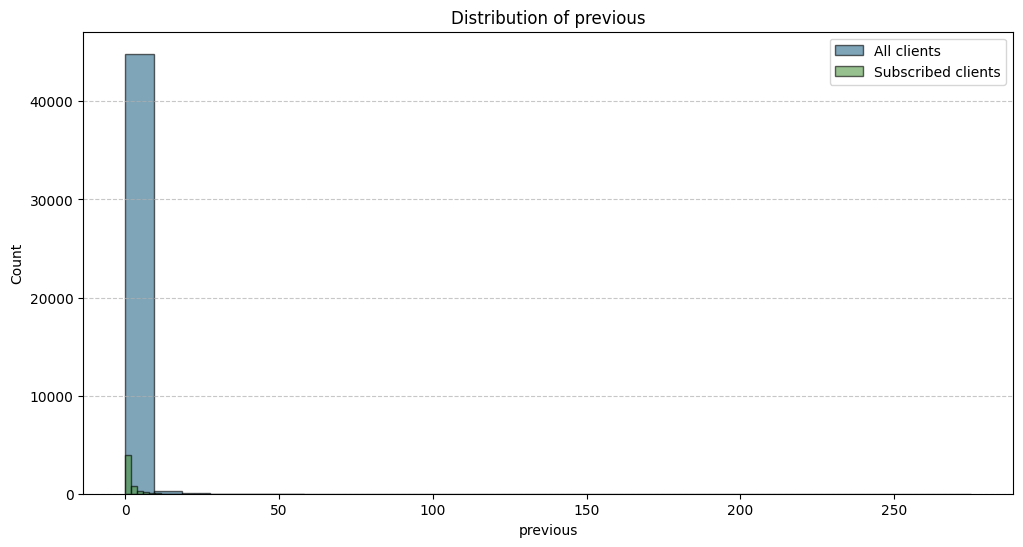

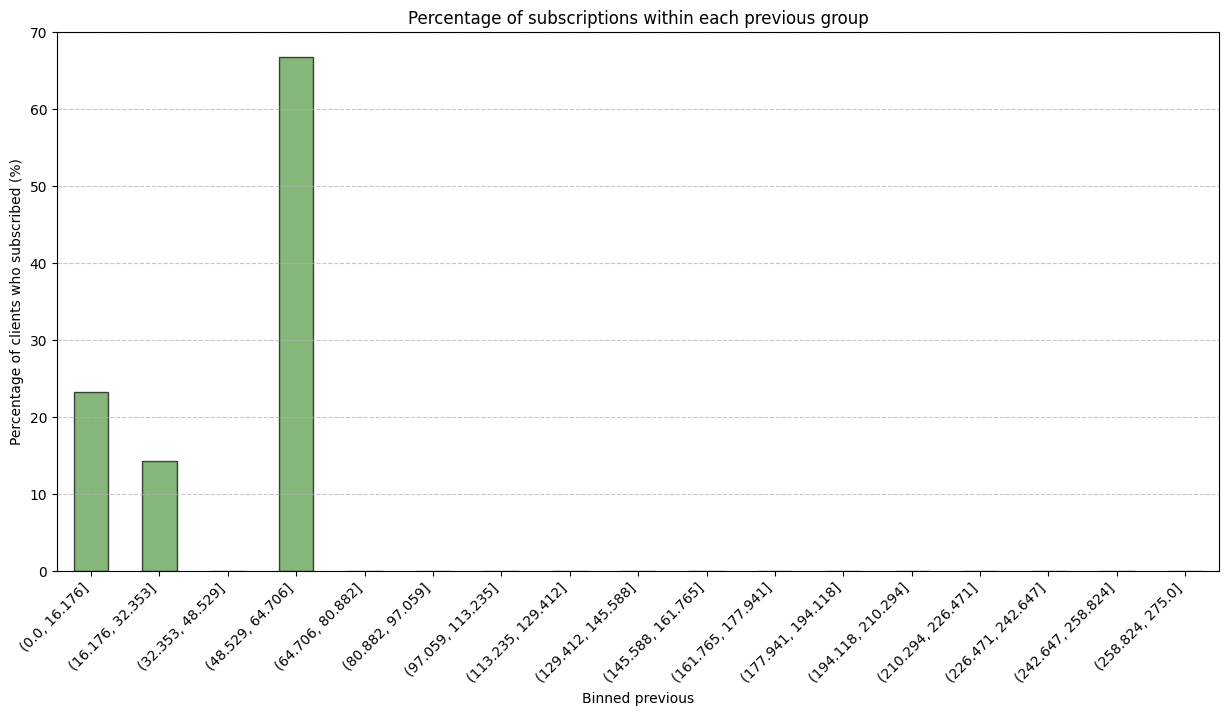

In [20]:
# Call the function to analyze the 'previous' column
analyze_column(raw_df, 'previous')

**Analysis:**  

- Most clients had very few previous contacts — `from 0 to 10`.  
- Among those who subscribed, the majority were clients with a small number of previous contacts.  
- Very few clients had more than `10` previous contacts.  
- The highest subscription rate (around `60-70%`) was observed among clients who had `48-65` previous contacts, but such clients are rare.  
- The second largest group among those who subscribed is clients who had `up to 33` previous contacts.  



#### Analysis Of Column `poutcome`

Analyzing categorical column: poutcome

Data type: object
Number of unique values: 4

Unique values:
['unknown' 'failure' 'other' 'success']

Value counts:
poutcome
unknown    36959
failure     4901
other       1840
success     1511
Name: count, dtype: int64


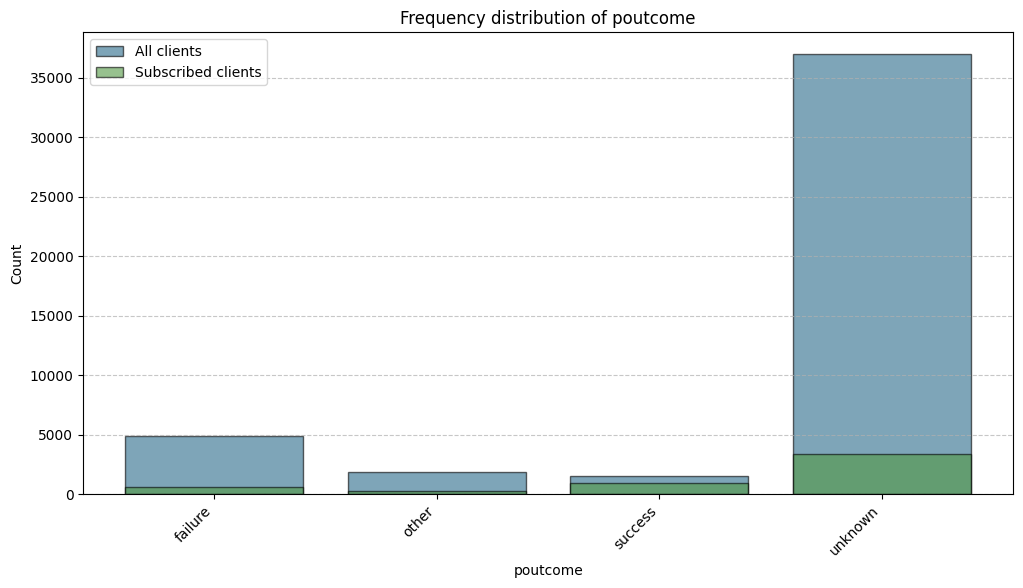

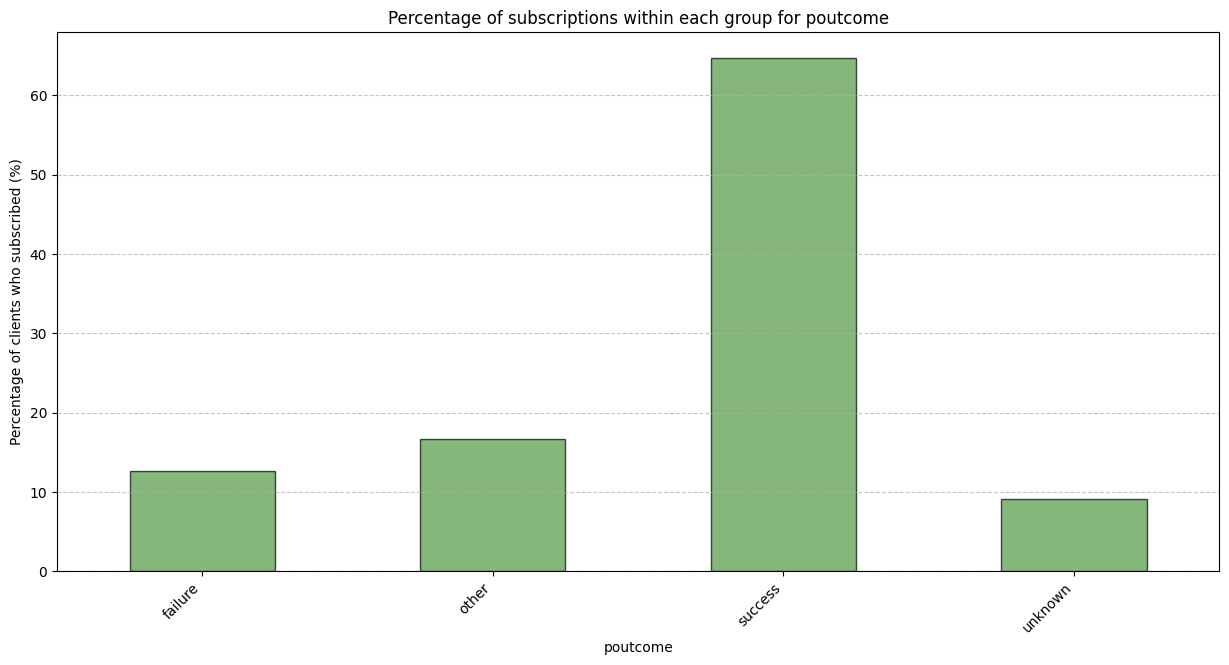

In [21]:
# Call the function to analyze the 'poutcome' column
analyze_column(raw_df, 'poutcome')

**Analysis:**  

- The vast majority of clients have a value of `unknown`.  
- A small number of clients were classified as `failure` or `success`.  
- The highest subscription rate (`around 60%`) is observed among clients for whom the result of the previous campaign was successful (`success`).  
- Clients with a `failure` or `other` result have a significantly lower subscription rate (`around 10-15%`), which may indicate that a previous negative experience reduces their willingness to subscribe in the current campaign.  

**Conclusions:**  
- Overall, these charts indicate that clients who had a positive experience with the previous campaign are much more likely to subscribe to new offers than others. This insight can help identify the target audience for future campaigns.  


#### Analysis Of Column `y`

Percentage distribution of 'y':
no: 88.30%
yes: 11.70%


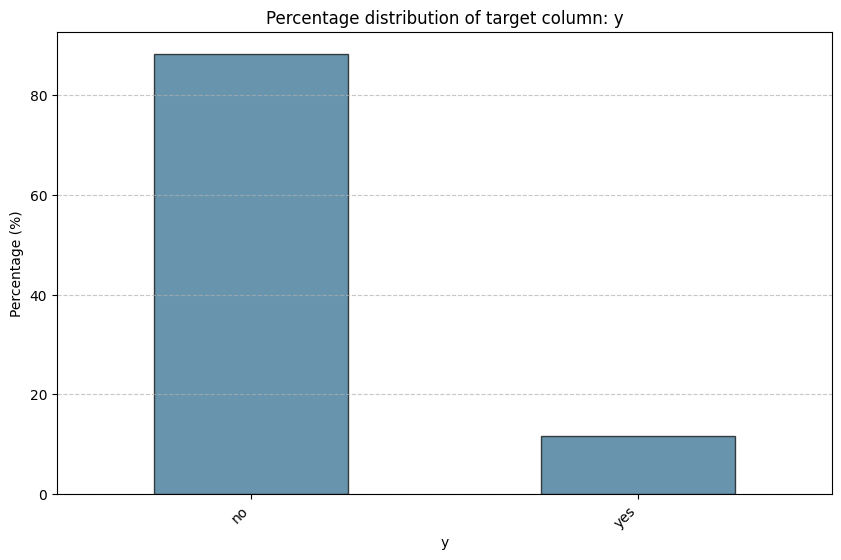

In [22]:
# Call the function to analyze the target column
analyze_target_column(raw_df, 'y')

**Distribution of Target Variable:**  

- `88.30%` of clients have the value `no`, indicating they did not subscribe.  
- `11.70%` of clients have the value `yes`, indicating they subscribed.  

**Analysis:**  

- The chart shows that the distribution between classes is very imbalanced — the vast majority of clients did not subscribe.  
  The target variable is unbalanced because the number of clients who did not subscribe significantly exceeds the number of those who did (almost 9:1).  

- This is crucial to consider when building a machine learning model, as the model may be inclined to predict the `no` value more often, ignoring the smaller group of subscribed clients.

**Conclusions:**  
Approaches that work for unbalanced data should be used, such as:  
- **Oversampling** (increasing the number of `yes` class examples).  
- **Undersampling** (reducing the number of `no` class examples).  
- Using metrics that are robust to unbalanced data, such as `F1-score`, `Precision`, `Recall`. I would choose `F1-score` as it is the best for unbalanced data and considers the balance between `Precision` and `Recall`. Additionally, I would look at the `ROC AUC` value to select the optimal threshold.  
- Imbalance handling techniques like `SMOTE`.  


**Hypotheses Regarding the Impact of Individual Features on the Target Variable `y`:**

**1. Age (`age`):**  
   The group of clients aged between `30 and 50 years` is the primary audience, which should be considered when conducting marketing campaigns.

**2. Job Type (`job`):**  
   Certain professions may have a greater interest in signing up for a deposit. For example, people in high-income positions might be more inclined to subscribe to a term deposit.

**3. Balance (`balance`):**  
   Clients with a higher account balance are likely to be more inclined to subscribe to deposits.

**4. Success of the Previous Campaign (`previous`):**  
   Clients who had more previous contacts might be more familiar with the bank's products and have a higher interest in subscribing.


### Data preprocessing

In [23]:
# List of categorical columns to encode (more than two categories)
obj_columns = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']

# List of binary columns to encode (two categories)
binary_columns = ['default', 'housing', 'loan', 'y']

In [24]:
# Apply encoding function to the raw DataFrame using specified columns.
df = encode_categorical_columns(raw_df, obj_columns, binary_columns)
df.head()

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,job_technician,job_unemployed,job_unknown,marital_married,marital_single,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
0,58,0,2143,1,0,5,261,1,-1,0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,44,0,29,1,0,5,151,1,-1,0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,33,0,2,1,1,5,76,1,-1,0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,47,0,1506,1,0,5,92,1,-1,0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,33,0,1,0,0,5,198,1,-1,0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


### Detecting outliers

In [34]:
# Define columns for which to detect outliers
columns_to_check = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Detect outliers using the IQR method
outliers = detect_outliers(df, columns=columns_to_check, method='zscore', threshold=4)

# Calculate the percentage of outliers in the current DataFrame
calculate_outlier_percentage(outliers, len(df))


Percentage of data that are outliers: 4.36%


4.36

In [35]:
# Handle outliers in the DataFrame using the specified method ('cap') 
df = handle_outliers(df, outliers, method='cap')

In [36]:
# Detect outliers again after handling and calculate the updated percentage
outliers_after = detect_outliers(df, int_columns, method='zscore', threshold=4)
calculate_outlier_percentage(outliers_after, len(df))

Percentage of data that are outliers: 0.0%


0.0

- The outlier treatment was performed using the `cap` method (i.e., capping outliers to the `IQR` boundaries), and the number of rows remained unchanged (`45,211`).  
- Increasing the `threshold` from `1.5 to 4` reduced the percentage of outliers to a more acceptable level (`from 66.70% to 4.36%`).  


### Scaling of numerical features

In [37]:
# Scale numeric features
scaler = MinMaxScaler()
df[int_columns] = scaler.fit_transform(df[int_columns])

In [38]:
# Display the first 5 rows of the DataFrame to preview the current state of data
df.head()

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,job_technician,job_unemployed,job_unknown,marital_married,marital_single,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
0,0.761905,0,0.756822,1,0,0.133333,0.405910,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.495238,0,0.367072,1,0,0.133333,0.234837,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,0.285714,0,0.362094,1,1,0.133333,0.118196,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.552381,0,0.639381,1,0,0.133333,0.143079,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.285714,0,0.361910,0,0,0.133333,0.307932,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


### Save the processed DataFrame

In [39]:
# Save the processed DataFrame to CSV
df.to_csv('data/processed/processed_data.csv', index=False)

### Split data into training and test sets in a ratio of 20/80

In [40]:
# Split data into features and target
X = df.drop('y', axis=1)
y = df['y']

# Split the dataset into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=29)

### Training and evaluation of the model

In [41]:
# Initialize results table
results_table = pd.DataFrame(columns=['Model', 
                                      'Hyperparameters', 
                                      'F1 Score (Train)', 
                                      'F1 Score (Test)', 
                                      'ROC AUC Score', 
                                      'Threshold', 
                                      'Comments'])

### Logistic Regression

F1 Score (Test): 0.44
ROC AUC Score: 0.89


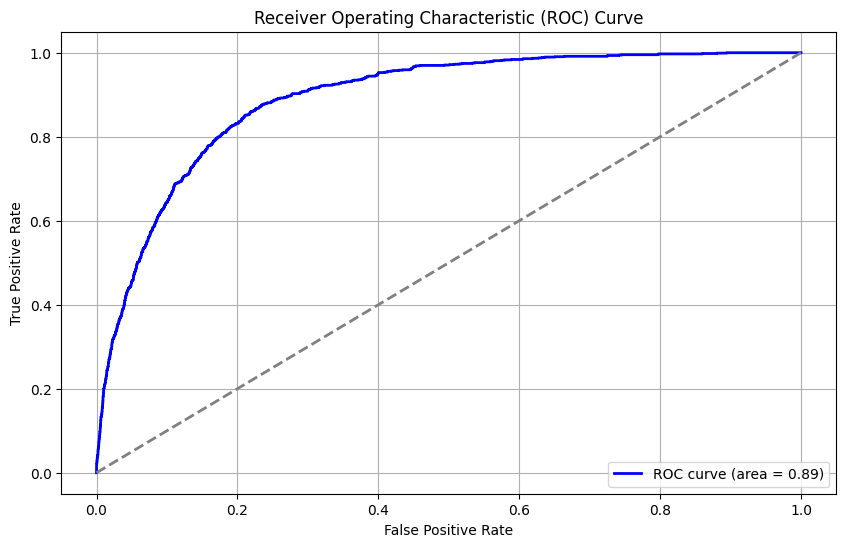

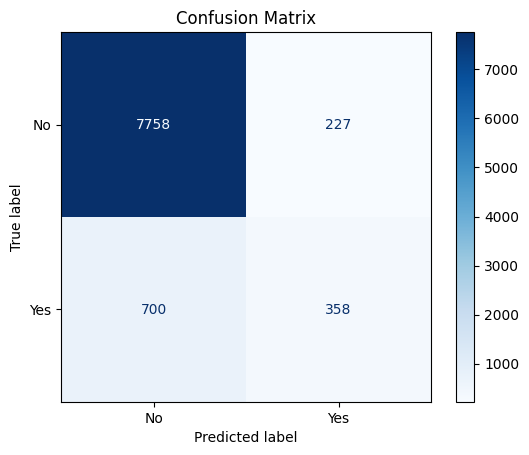

In [47]:
# Initialize a Logistic Regression model with specified solver and random state
model = LogisticRegression(solver='liblinear', random_state=29)

# Train and evaluate the model, then update the results table with the evaluation results
results_table = train_and_evaluate_model(model, 
                                         X_train, 
                                         X_test, 
                                         y_train, 
                                         y_test, 
                                         model_name='Logistic Regression', 
                                         hyperparameters='solver=liblinear, random_state=29', 
                                         results_table=results_table)

In [51]:
# Add comments into result table for the Logistic Regression model
results_table = update_comments(results_table, 'Logistic Regression', 'High ROC AUC but low F1: the model ranks well but has issues with the threshold, leading to low Recall for the "Yes" class. It is worth adjusting the threshold to reduce False Negatives (FN). I would not use this model.')

**Analysis:**  
A high ROC AUC score, but a low F1 score indicates that while the model ranks predictions well, it has issues with the actual decision threshold, leading to an imbalance in true positive and true negative rates.

The confusion matrix shows that the model struggles with correctly predicting the `Yes` class (clients who subscribed to a term deposit).

This means that the model has high accuracy in identifying clients who did not subscribe, but performs poorly in predicting clients who did subscribe (high number of `FN` — false negatives). This can be a problem for the business, as potential clients who might subscribe to a deposit are being missed.

**To improve the model:**  
- Try adjusting the prediction threshold to increase Recall.


In [53]:
# Calculate probabilities for the positive class using the trained model.
y_probs = model.predict_proba(X_test)[:, 1]

# Compute false positive rate, true positive rate, and thresholds using the ROC curve.
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calculate the Youden's index to find the optimal threshold.
youden_index = tpr - fpr
optimal_threshold = thresholds[np.argmax(youden_index)]

# Print the optimal threshold value.
print(f"Optimal threshold: {round(optimal_threshold, 2)}")

Optimal threshold: 0.08


F1 Score (Test): 0.48
ROC AUC Score: 0.89


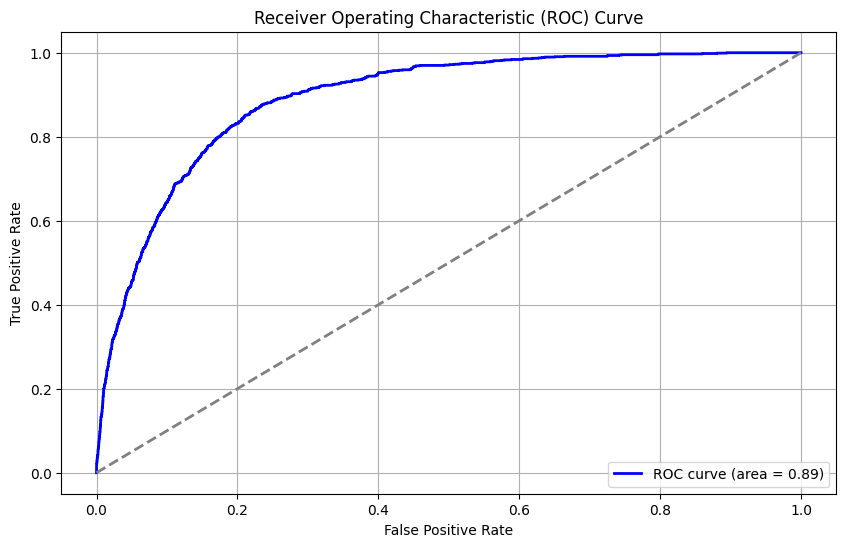

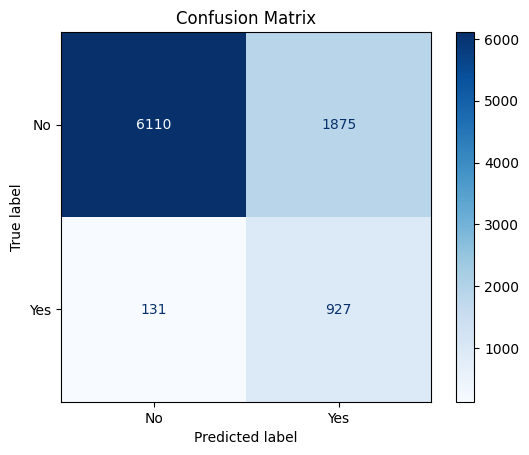

In [54]:
# Train and evaluate model with adjusted threshold
results_table = train_and_evaluate_model(model, 
                                         X_train, 
                                         X_test, 
                                         y_train, 
                                         y_test, 
                                         threshold=optimal_threshold, 
                                         model_name='Logistic Regression (Adjusted Threshold)', 
                                         hyperparameters=f'solver=liblinear, random_state=29, threshold={optimal_threshold}', 
                                         results_table=results_table)

In [55]:
# Add comments to Logistic Regression model with adjusted threshold
results_table = update_comments(results_table, 
                                'Logistic Regression (Adjusted Threshold)', 
                                'Threshold optimization improved F1 from 0.44 to 0.48 by balancing Precision and Recall: FN decreased and TP increased, but FP also rose. ROC AUC remained at 0.89, indicating an unchanged ability of the model to distinguish classes. Overall, I would not use this model.')

**Analysis:**  

- It is evident that after adjusting the optimal threshold, the `F1 Score` improved from `0.44 to 0.48`. This indicates that the model is now better balancing `Precision` and `Recall`, reducing the number of false negatives and improving the identification of true positive cases.

- However, the `ROC AUC` value remained at `0.89`, suggesting that the model's ability to distinguish between positive and negative classes has not changed.

- Lowering the threshold increased the number of `True Positives (TP)` and reduced `False Negatives (FN)`, which improved the sensitivity (`Recall`). However, this led to a significant increase in `False Positives (FP)`, which negatively affected `Precision`. Therefore, the `F1-Score` slightly increased to `0.48`, as it represents a compromise between `Precision` and `Recall`.

**Conclusion:**  
The optimal threshold reduced missed cases (`FN`) and increased the number of correctly predicted subscriptions (`TP`). This helped balance the model, improving its ability to detect subscribed clients, albeit at the cost of a higher number of false positive predictions. The `ROC AUC` remained at `0.89`.

### kNN

In [56]:
# Create copies of the training and test data to preserve the original values.
X_train_np = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
y_train_np = y_train.values if isinstance(y_train, pd.Series) else y_train
X_test_np = X_test.values if isinstance(X_test, pd.DataFrame) else X_test
y_test_np = y_test.values if isinstance(y_test, pd.Series) else y_test

In [57]:
# Perform grid search for hyperparameter tuning of KNN.
param_grid = {'n_neighbors': np.arange(1, 21)}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='f1_macro', error_score='raise')

# Fit the grid search to the training data.
grid_search.fit(X_train_np, y_train_np)

# Print the optimal value for n_neighbors found by the grid search.
print(f"Optimal value for n_neighbors: {grid_search.best_params_['n_neighbors']}")

Optimal value for n_neighbors: 3


F1 Score (Test): 0.40
ROC AUC Score: 0.76


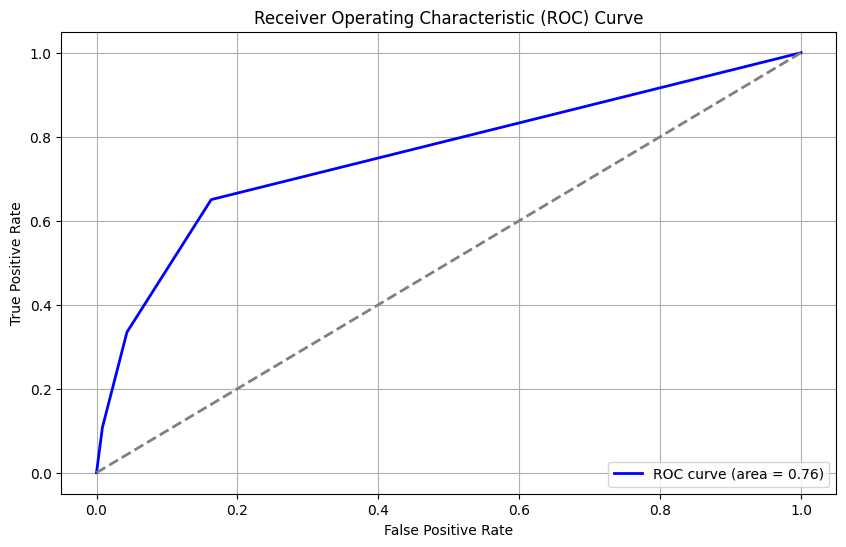

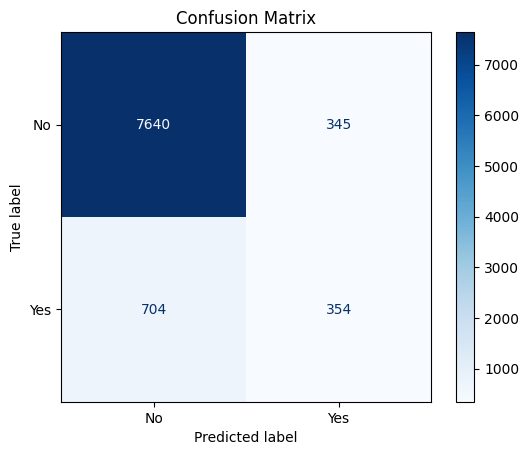

In [58]:
# Train and evaluate KNN model with optimal n_neighbors
n_neighbors_optimal = grid_search.best_params_['n_neighbors']
knn_model = KNeighborsClassifier(n_neighbors=n_neighbors_optimal)
results_table = train_and_evaluate_model(knn_model, 
                                         X_train_np, 
                                         X_test_np, 
                                         y_train_np, 
                                         y_test_np,
                                         model_name=f'KNN (n_neighbors={n_neighbors_optimal})',
                                         hyperparameters=f'n_neighbors={n_neighbors_optimal}',
                                         results_table=results_table)

**Analysis:**  

- After performing grid search (`GridSearchCV`), the optimal value for `n_neighbors` in the `KNN` model was set to `3`. This indicates that the best result was achieved by considering the three nearest neighbors for each prediction.

**Model Quality Metrics (`F1 Score` and `ROC AUC`):**  

- The `F1 Score` on the test set is `0.40`. This suggests that the balance between `Precision` and `Recall` is not ideal, especially for the `Yes` class.  
- The `ROC AUC` is `0.76`. This is an average value that indicates that the model generally has a good ability to differentiate between classes, but it is not yet optimal.

**Confusion Matrix:**  

- The confusion matrix shows that the model has many `False Negatives`, which reduces the `Recall` for the `Yes` class. This is a significant issue that requires either adjusting the threshold or considering other models.

**Next Steps:**  
Adjusting the threshold, as was done for the Logistic Regression model, could help improve the balance between `TP` and `FN`.

In [61]:
# Calculate probabilities for the positive class using the trained KNN model.
y_probs_knn = knn_model.predict_proba(X_test_np)[:, 1]

# Compute false positive rate, true positive rate, and thresholds for KNN using the ROC curve.
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_probs_knn)

# Calculate the Youden's index to find the optimal threshold for KNN.
youden_index_knn = tpr_knn - fpr_knn
optimal_threshold_knn = thresholds_knn[np.argmax(youden_index_knn)]

# Print the optimal threshold value for KNN.
print(f"Optimal threshold for KNN: {round(optimal_threshold_knn, 2)}")

Optimal threshold for KNN: 0.33


F1 Score (Test): 0.45
ROC AUC Score: 0.76


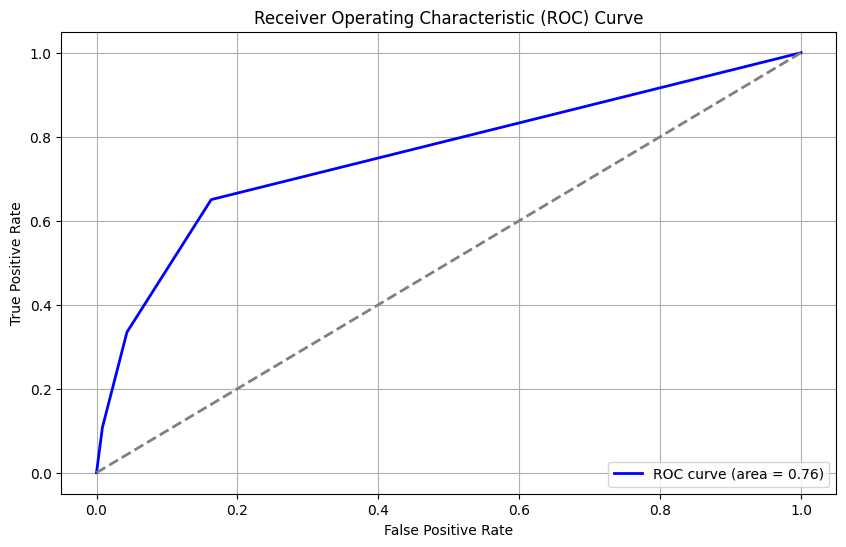

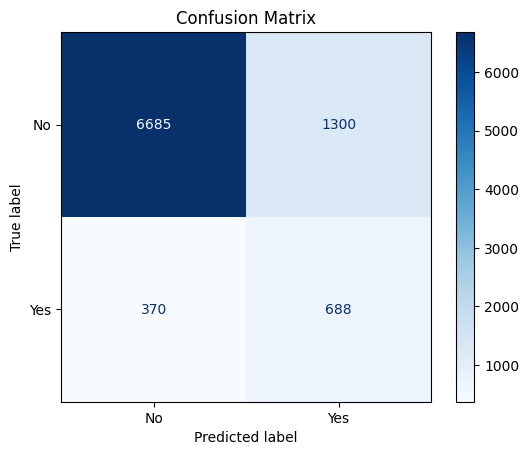

In [62]:
# Train and evaluate KNN model with adjusted threshold
results_table = train_and_evaluate_model(knn_model,
                                         X_train_np,
                                         X_test_np,
                                         y_train_np,
                                         y_test_np,
                                         threshold=optimal_threshold_knn,
                                         model_name=f'KNN (Adjusted Threshold, n_neighbors={n_neighbors_optimal})',
                                         hyperparameters=f'n_neighbors={n_neighbors_optimal}, threshold={round(optimal_threshold_knn, 2)}',
                                         results_table=results_table)

In [63]:
# Add comments to KNN model
results_table = update_comments(results_table,
                                f'KNN (n_neighbors={n_neighbors_optimal})',
                                'After GridSearchCV, the optimal n_neighbors is 3. F1 = 0.40, indicating an imbalance between Precision and Recall for the "Yes" class. The confusion matrix shows a high FN, reducing Recall. It may be worthwhile to adjust the threshold or try other models.')

# Add comments to KNN model with adjusted threshold
results_table = update_comments(results_table,
                                f'KNN (Adjusted Threshold, n_neighbors={n_neighbors_optimal})',
                                'The optimal threshold for KNN is 0.33. F1 increased to 0.45, and the balance between Precision and Recall improved. Lowering the threshold increased "Yes" predictions, but FP also rose. Next steps: test other models to reduce FP.')

**Analysis:**  

- The optimal threshold for the KNN model was set to `0.33`. This value was chosen to improve the balance between `True Positives` and `False Positives` using the `Youden index`.

**Model Quality Metrics (F1 Score and ROC AUC):**  

- The `F1 Score` on the test set increased to `0.45`. This indicates that adjusting the threshold indeed had a positive impact on the balance between `Precision` and `Recall`, improving the prediction quality for the minority class.  
- The `ROC AUC` remained at `0.76`, suggesting that the overall ability of the model to differentiate between classes did not change significantly after optimizing the threshold.

**Confusion Matrix:**  

- **False Positives (FP):** `1300` instances were incorrectly classified as `Yes`. Compared to the previous version, the number of `FP` increased, which is a consequence of lowering the threshold to increase the number of positive predictions.  
- **False Negatives (FN):** `370` instances were incorrectly classified as `No`. The number of `FN` decreased significantly, indicating that the model improved in predicting the positive class.  
- **True Positives (TP):** `688` instances were correctly classified as `Yes`. The number of `TP` increased, pointing to improved prediction quality for the positive class.

**Conclusion:**  
Optimizing the threshold had a positive effect on the balance between `Precision` and `Recall`. The `F1 Score` increased, indicating an overall improvement in the model's performance for both classes. The increase in `False Positives` suggests that lowering the threshold led to more `Yes` predictions.

**Next Steps:**  
It is recommended to try other models to reduce the number of `False Positives` while maintaining a low level of `False Negatives`.


### Decision Tree

F1 Score (Test): 0.40
ROC AUC Score: 0.66


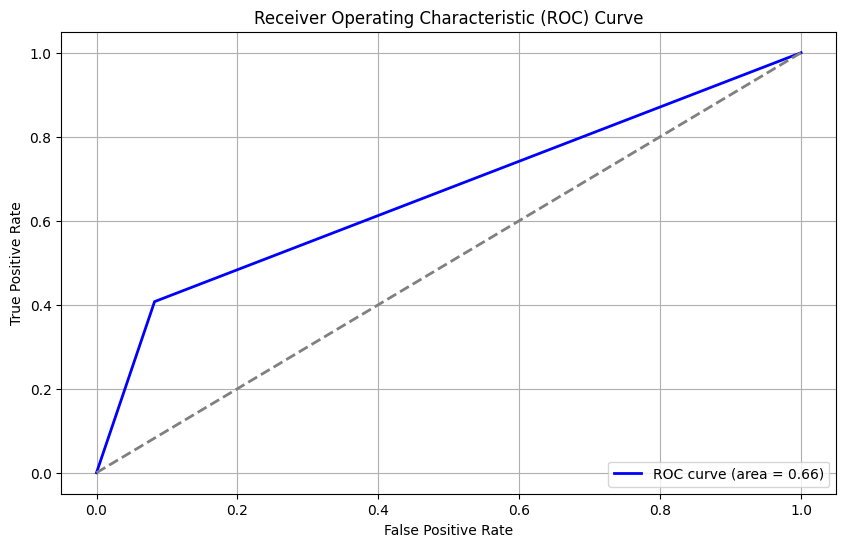

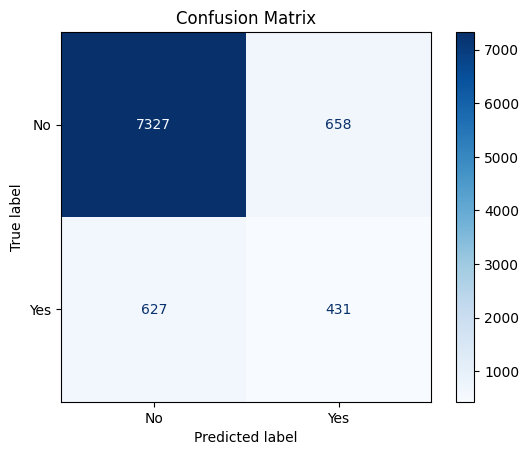

In [64]:
# Train and evaluate Decision Tree model
dt_model = DecisionTreeClassifier(random_state=29)
results_table = train_and_evaluate_model(dt_model, 
                                         X_train, 
                                         X_test, 
                                         y_train, 
                                         y_test, model_name='Decision Tree', 
                                         hyperparameters='random_state=29', 
                                         results_table=results_table)

In [65]:
print(f"F1 Score (Train) для Decision Tree: {results_table.loc[results_table['Model'] == 'Decision Tree', 'F1 Score (Train)'].values[0]}")

F1 Score (Train) для Decision Tree: 1.0


**Analysis:**  

- The `F1 Score` on the training set is `1.0`. This indicates that the model is overfitted and fits the training set too perfectly.  
- The `F1 Score` on the test set is `0.40`. This suggests that the model has average predictive ability but clearly faces issues with balancing `Precision` and `Recall`, especially for the `Yes` class.  
- The `ROC AUC` is `0.66`. This is lower compared to other models, indicating the model's limited ability to differentiate between positive and negative classes. A value of 0.66 means there is some ability to classify correctly, but it is far from ideal.  
- The `ROC` curve shows that the model does not have a strong classification ability: the curve is not far from the diagonal line of random prediction.

**Confusion Matrix:**  

- **True Negatives (TN):** `7327` instances were correctly classified as `No`.  
- **False Positives (FP):** `658` instances were incorrectly classified as `Yes`.  
- **False Negatives (FN):** `627` instances were incorrectly classified as `No`. This is quite a high number, negatively impacting the `Recall` metric.  
- **True Positives (TP):** `431` instances were correctly classified as `Yes`.

**Conclusion:**  

- The `ROC AUC = 0.66` and `F1 Score = 0.40` indicate insufficient performance of the `Decision Tree` model compared to other approaches.  
- The model has many false positives (`FP`) and false negatives (`FN`), indicating difficulty in correctly classifying instances.  
- `Decision Tree` tends to overfit, especially without proper regularization and control over the tree depth.

**Next Steps:**  
I will perform hyperparameter tuning to adjust the tree depth (`max_depth`) and the minimum number of samples required for splitting (`min_samples_split`) to avoid overfitting.


In [67]:
# Add comments to Decision Tree model
results_table = update_comments(results_table, 'Decision Tree', 'Firstly, the model is overfitting. It has limited ability to distinguish between classes. There is an issue with the balance between Precision and Recall for the "Yes" class. I would not use this model, but I will try to tune the hyperparameters for it.')

### Decision Tree (Optimized)

In [68]:
# Perform grid search for hyperparameter tuning of Decision Tree.
param_grid_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_dt = GridSearchCV(DecisionTreeClassifier(random_state=29), 
                              param_grid_dt, 
                              cv=5, 
                              scoring='f1_macro', 
                              error_score='raise')

# Fit the grid search to the training data.
grid_search_dt.fit(X_train, y_train)

# Print the optimal hyperparameters found by the grid search for Decision Tree.
print(f"Optimal hyperparameters for Decision Tree: {grid_search_dt.best_params_}")

Optimal hyperparameters for Decision Tree: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}


F1 Score (Test): 0.49
ROC AUC Score: 0.87


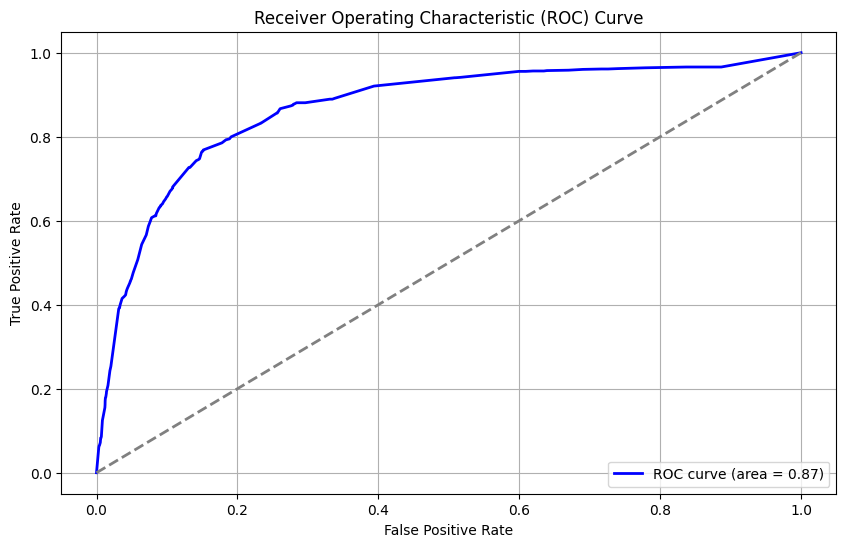

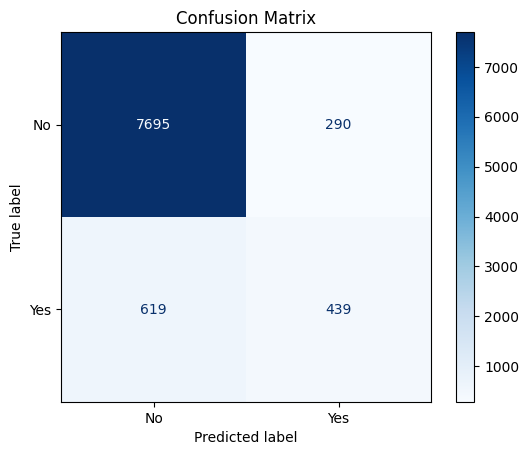

In [69]:
# Train and evaluate the Decision Tree model using the optimal hyperparameters found in grid search.
dt_model_optimal = DecisionTreeClassifier(**grid_search_dt.best_params_, random_state=29)

# Fit the model and update the results table with evaluation metrics.
results_table = train_and_evaluate_model(dt_model_optimal, 
                                         X_train, X_test, y_train, y_test,
                                         model_name='Decision Tree (Optimized)',
                                         hyperparameters=str(grid_search_dt.best_params_),
                                         results_table=results_table)


In [70]:
# Add comments to optimized Decision Tree model
results_table = update_comments(results_table,
                                'Decision Tree (Optimized)',
                                'Optimization improved F1 and ROC AUC. FP was reduced, TP increased, but FN remains high. Next steps: optimize max_depth, min_samples_split, or add regularization and pruning to decrease FN.')

**Analysis:**  

- The `F1 Score` on the test set is `0.49`, which is higher than the initial version of the Decision Tree (`F1 Score = 0.40`). The model optimization had a positive impact on its performance, indicating an improvement in the balance between `Precision` and `Recall`.  
- The `ROC AUC` is `0.87`, suggesting that the model has become significantly better at distinguishing between classes compared to the initial version (`ROC AUC = 0.66`). This indicates an improved ability to predict both classes.  
- The `ROC Curve` looks much better compared to the initial version of the `Decision Tree`. It lies closer to the top-left corner, which is a sign of better performance.

**Confusion Matrix:**  

- **True Negatives (TN):** `7695` instances were correctly classified as `No`, indicating high accuracy for the negative class.  
- **False Positives (FP):** `290` instances were incorrectly classified as `Yes`. This value has decreased, indicating fewer false positive predictions.  
- **False Negatives (FN):** `619` instances were incorrectly classified as `No`. The number of `FN` remains relatively high, which is a metric that needs further improvement to enhance `Recall`.  
- **True Positives (TP):** `439` instances were correctly classified as `Yes`. An increase in `TP` indicates improved ability of the model to correctly identify the positive class.

**Conclusion:**  

- The optimization of the `Decision Tree` significantly improved the model's performance. The increase in `F1 Score` from `0.40 to 0.49` and the rise in `ROC AUC` from `0.66 to 0.87` indicate that the model has become more accurate and better able to distinguish between classes.  
- The reduction in `FP` and the increase in `TP` indicate an overall improvement in the balance between `Precision` and `Recall`, but the high number of `FN` suggests a potential issue with underestimating positive cases.

**Next Steps:**  

- It may be worth optimizing hyperparameters such as `max_depth` and `min_samples_split` again to achieve better generalization and avoid overfitting.  
- Additionally, regularization could be added or tree pruning could be applied to avoid overfitting and reduce model complexity.  


### Decision Tree (Further Optimized)

In [71]:
# Perform grid search for further hyperparameter tuning of Decision Tree.
param_grid_dt2 = {
    'max_depth': [5, 15, 25],
    'min_samples_split': [3, 6, 9],
    'min_samples_leaf': [2, 3, 5]
}

grid_search_dt2 = GridSearchCV(DecisionTreeClassifier(random_state=29), 
                                param_grid_dt2, 
                                cv=5, 
                                scoring='f1_macro', 
                                error_score='raise')

# Fit the grid search to the training data.
grid_search_dt2.fit(X_train_np, y_train_np)

# Print the optimal hyperparameters found by the grid search for the new Decision Tree.
print(f"Optimal hyperparameters for the new Decision Tree: {grid_search_dt2.best_params_}")


Optimal hyperparameters for the new Decision Tree: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 3}


F1 Score (Test): 0.43
ROC AUC Score: 0.85


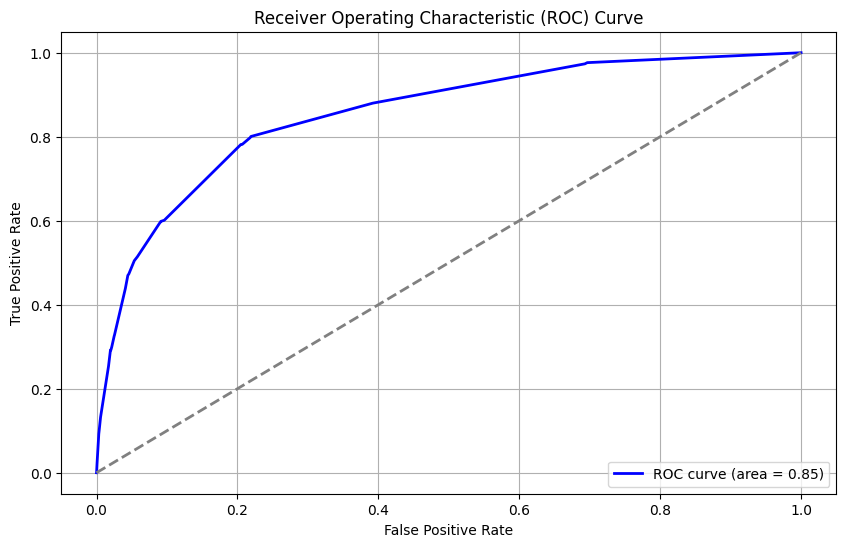

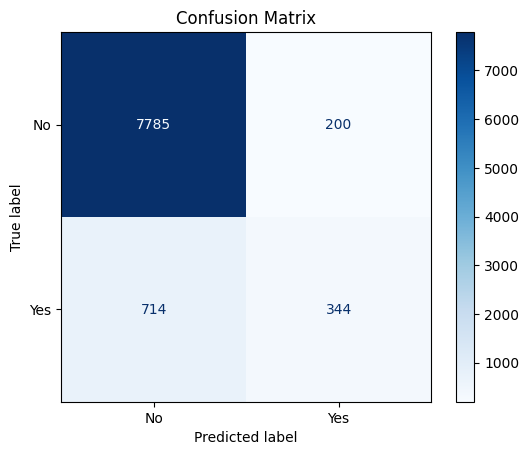

In [72]:
# Train and evaluate the new Decision Tree model using further optimized hyperparameters from the grid search.
dt_model_2 = DecisionTreeClassifier(**grid_search_dt2.best_params_, random_state=29)

# Fit the model and update the results table with evaluation metrics.
results_table = train_and_evaluate_model(dt_model_2, 
                                         X_train_np, 
                                         X_test_np, 
                                         y_train_np, 
                                         y_test_np, 
                                         model_name='Decision Tree (Further Optimized)', 
                                         hyperparameters=str(grid_search_dt2.best_params_), 
                                         results_table=results_table)


In [74]:
# Add comments to new Decision Tree model
results_table = update_comments(results_table, 'Decision Tree (Further Optimized)', 'The model has become more sensitive to the negative class but worse at recognizing positive cases. FP has decreased, but FN has increased. I will try adding regularization or pruning the tree.')

**Analysis:**  

- The `F1 Score` on the test set for this model is `0.43`. This value is lower than the previous optimized model (`0.49`). This may indicate that the chosen depth and other parameters were not optimal for the current task, and the model was unable to achieve a better balance between `Precision` and `Recall`.  
- The `ROC AUC` for this model is `0.85`, which is slightly lower compared to the previous optimized version (`0.87`). Overall, the model distinguishes between classes well, but with less confidence than the previous version.  
- The `ROC AUC = 0.85` indicates good model performance, but not as high as the previous optimized model (`0.87`).

**Confusion Matrix:**  

- Overall, the confusion matrix metrics are slightly lower than those of the previous model.

**Conclusion:**  

- Despite additional optimization, the `F1 Score` decreased to `0.43`, which may indicate that the model has become more specific to the negative class and worse at identifying positive cases.  
- Reduction in false positive predictions (`FP`): This suggests that the model has become more cautious in predicting the `Yes` class. However, an increase in false negative predictions (`FN`) indicates that the model sacrifices sensitivity to improve precision.

**Next Steps:**  

- I will attempt to add regularization or apply tree pruning to avoid overfitting and reduce model complexity.


### Decision Tree (Optimized with Pruning)

In [77]:
# Find the optimal ccp_alpha for pruning by calculating the pruning path of the Decision Tree.
path = DecisionTreeClassifier(**grid_search_dt.best_params_, random_state=29).cost_complexity_pruning_path(X_train, y_train)
alphas = path.ccp_alphas

# Define the parameter grid for ccp_alpha.
param_grid_pruning = {'ccp_alpha': alphas}

# Perform grid search to find the best ccp_alpha value for pruning.
grid_search_pruning = GridSearchCV(DecisionTreeClassifier(**grid_search_dt.best_params_, 
                                                          random_state=29), 
                                   param_grid_pruning, 
                                   cv=5, 
                                   scoring='f1_macro', 
                                   error_score='raise')

# Fit the grid search to the training data.
grid_search_pruning.fit(X_train, y_train)

# Print the optimal value for ccp_alpha found by the grid search.
print(f"Optimal ccp_alpha value for pruning the tree: {round(grid_search_pruning.best_params_['ccp_alpha'], 4)}")

Optimal ccp_alpha value for pruning the tree: 0.0012


F1 Score (Test): 0.51
ROC AUC Score: 0.84


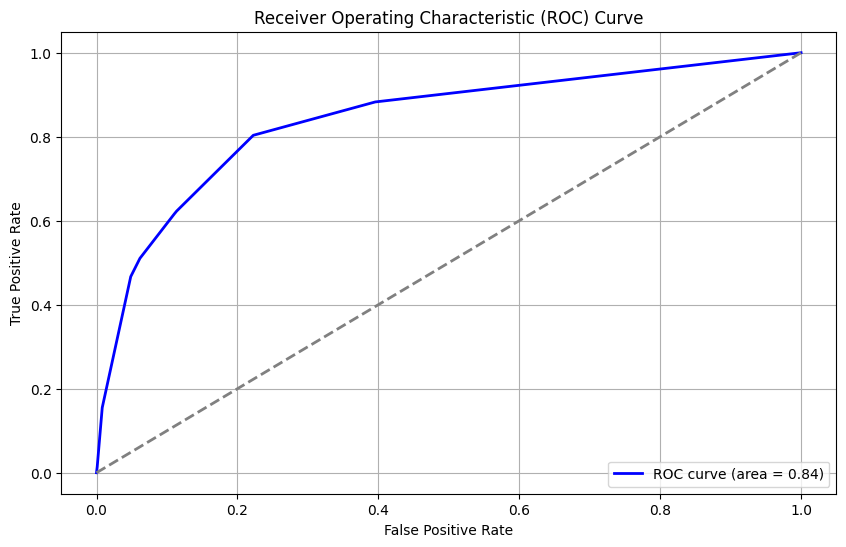

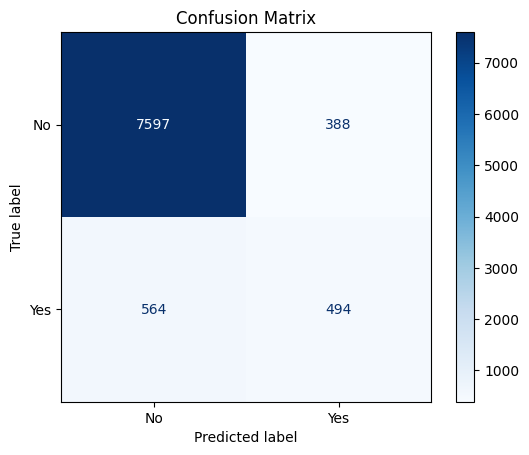

In [78]:
# Train and evaluate the new Decision Tree model with optimized parameters and pruning.
dt_model_optimized = DecisionTreeClassifier(**grid_search_dt.best_params_, 
                                            random_state=29, 
                                            ccp_alpha=grid_search_pruning.best_params_['ccp_alpha'])

# Fit the model and update the results table with evaluation metrics.
results_table = train_and_evaluate_model(dt_model_optimized, 
                                         X_train, X_test, y_train, y_test, 
                                         model_name='Decision Tree (Optimized with Pruning)', 
                                         hyperparameters=str(grid_search_dt.best_params_) + 
                                         f", ccp_alpha={grid_search_pruning.best_params_['ccp_alpha']}", 
                                         results_table=results_table)

**Analysis:**  

- The `F1 Score` on the test set for this model is `0.51` — the new model showed an improvement in `F1` on the test data compared to previous models (without pruning). This indicates an improved balance between `Precision` and `Recall`, especially for the `Yes` class.  
- The `ROC AUC` for this model is `0.84` — this metric suggests that the model with `ccp_alpha` optimization distinguishes positive and negative classes well, although the result is slightly lower compared to previous models (`0.87` and `0.85`).

**Confusion Matrix:**  

- **True Positive (TP):** `494` — improved compared to the previous model without pruning, indicating that the model is better at identifying `Yes` classes.

**Conclusion:**  

- Pruning (`ccp_alpha`) helped reduce the complexity of the model and avoid overfitting, which improved its generalization capability.  
- The pruned model is more stable and has a better balance between errors of both types (`FN` and `FP`).  

**Next Steps:**  

- For now, I would choose this model since it has shown the best results (`F1 Score (Test)`) in terms of generalization and balance between `Precision` and `Recall` for the current dataset.


In [80]:
# Add comments to new pruned Decision Tree model
results_table = update_comments(results_table, 'Decision Tree (Optimized with Pruning)', 'The model with ccp_alpha pruning improved the balance between Precision and Recall, leading to better identification of "Yes" classes. Pruning reduced overfitting and enhanced generalization. I would choose this model for further work.')

### Random Forest (Optimized)

In [82]:
# Initialize the Random Forest model with a fixed random state for reproducibility.
rf_model = RandomForestClassifier(random_state=29)

# Define a narrower parameter grid based on previously found best parameters for fine-tuning.
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [15, 20, 20],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2],
    'ccp_alpha': [0.0, 0.01]
}

# Conduct the grid search with cross-validation to find the best hyperparameters.
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='f1_macro', error_score='raise')
grid_search_rf.fit(X_train, y_train)

# Print the best hyperparameters found by the grid search for the Random Forest model.
print(f"Optimal hyperparameters for Random Forest: {grid_search_rf.best_params_}")

Optimal hyperparameters for Random Forest: {'ccp_alpha': 0.0, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


F1 Score (Test): 0.45
ROC AUC Score: 0.90


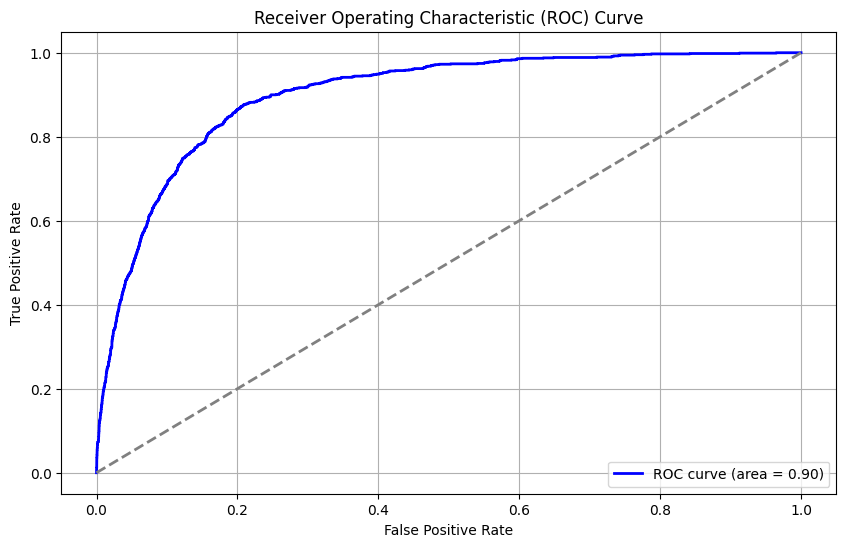

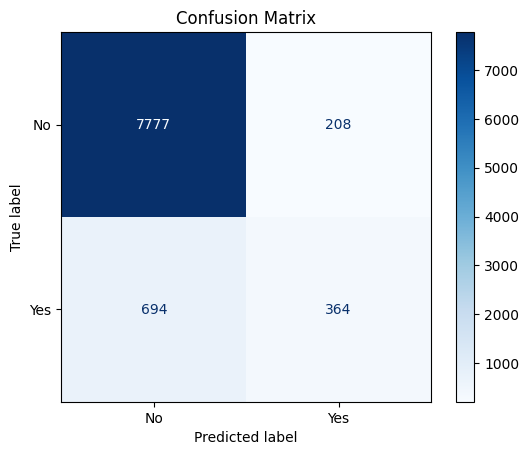

In [84]:
# Initialize the Random Forest model with the optimized parameters from grid search.
rf_model_optimized = RandomForestClassifier(**grid_search_rf.best_params_, random_state=29)

# Fit the model and update the results table with evaluation metrics.
results_table = train_and_evaluate_model(rf_model_optimized, 
                                         X_train, X_test, y_train, y_test, 
                                         model_name='Random Forest (Optimized)', 
                                         hyperparameters=str(grid_search_rf.best_params_), 
                                         results_table=results_table)

In [86]:
# Add comments to Random Forest (Optimized) model
results_table = update_comments(results_table, 'Random Forest (Optimized)', 'The model distinguishes classes well but has high FN (694), which lowers Recall. Next steps: lower the threshold to increase Recall and reduce FN.')

**Analysis:**  

- The `F1 Score` on the test set is `0.45`, indicating a balance between `Precision` and `Recall`. This is not a very high value, and there is potential for improvement.  
- The `ROC AUC` is `0.90`, which is an excellent indicator. This means that the model is quite good at distinguishing between the `Yes` and `No` classes overall.

**Confusion Matrix:**  
- **True Negatives (TN):** `7777` — correctly classified samples of the `No` class.  
- **False Positives (FP):** `208` — samples incorrectly classified as `Yes`, though they belong to the `No` class.  
- **False Negatives (FN):** `694` — samples incorrectly classified as `No`, though they belong to the `Yes` class.  
- **True Positives (TP):** `364` — correctly classified samples of the `Yes` class.

**Conclusion:**  

- The model performs well on test data in terms of overall ability to distinguish classes (`ROC AUC = 0.90`), but it has a low `F1 Score`, particularly due to the high number of false negatives (`FN = 694`). The model frequently fails to recognize positive cases, which can be critical, especially if those cases are important for the business process.

**Next Steps:**  

- Lowering the threshold (`threshold`) may improve `Recall`, allowing the model to reduce the number of false negatives (`FN`). Increasing `TP` will help raise the `F1 Score`, though it may lead to an increase in `FP`.


### Random Forest (Adjusted Threshold)

In [87]:
# Calculate probabilities for the positive class using the optimized Random Forest model.
y_probs_rf = rf_model_optimized.predict_proba(X_test)[:, 1]

# Compute false positive rate, true positive rate, and thresholds using the ROC curve for Random Forest.
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_probs_rf)

# Calculate the Youden's index to find the optimal threshold for Random Forest.
youden_index_rf = tpr_rf - fpr_rf
optimal_threshold_rf = thresholds_rf[np.argmax(youden_index_rf)]

# Print the optimal threshold value for the Random Forest model.
print(f"Optimal threshold for Random Forest: {optimal_threshold_rf}")


Optimal threshold for Random Forest: 0.10749947540045453


F1 Score (Test): 0.51
ROC AUC Score: 0.90


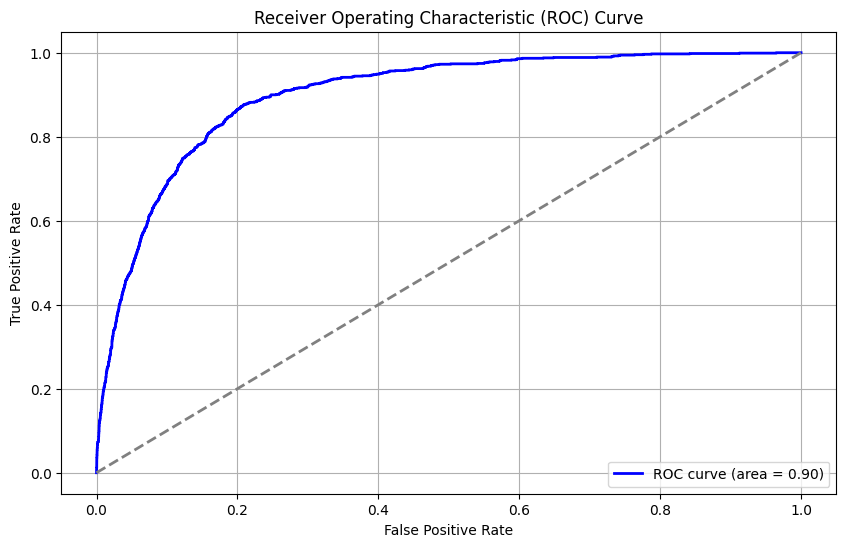

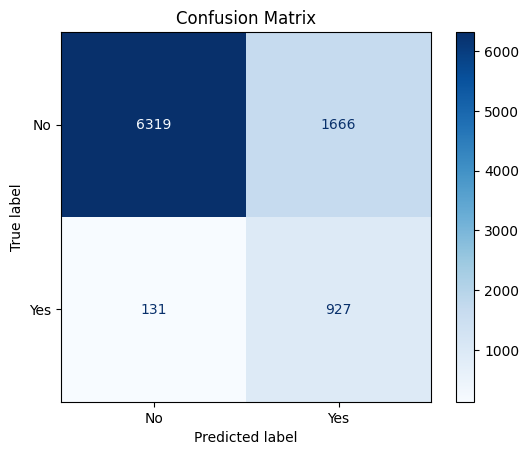

In [88]:
# Train and evaluate Random Forest model with adjusted threshold
results_table = train_and_evaluate_model(rf_model_optimized, 
                                         X_train, X_test, y_train, y_test, 
                                         threshold=optimal_threshold_rf, 
                                         model_name='Random Forest (Adjusted Threshold)', 
                                         hyperparameters=str(grid_search_rf.best_params_) + f', threshold={optimal_threshold_rf}', 
                                         results_table=results_table)

In [89]:
# Add comments to Random Forest (Adjusted Threshold) model
results_table = update_comments(results_table, 'Random Forest (Adjusted Threshold)', "Adjusting the threshold improved the model's performance by balancing Precision and Recall. FN significantly decreased, which is important for positive cases, but FP is still high. Conclusion: the model is effective and suitable for use, but efforts should continue to reduce FP.")

**Analysis:**  

- The `F1 Score` on the test set is `0.51`. This means that after adjusting the threshold, the model's performance improved compared to the previous result, especially in balancing `Precision` and `Recall`.  
- The `ROC AUC` is `0.90`, which is an excellent indicator. This means that the model is quite good at distinguishing between `Yes` and `No` classes overall.

**Confusion Matrix:**  

- **True Negatives (TN):** `6319` — correctly classified samples of the `No` class.  
- **False Positives (FP):** `1666` — samples incorrectly classified as `Yes`, though they belong to the `No` class.  
- **False Negatives (FN):** `131` — samples incorrectly classified as `No`, though they belong to the `Yes` class.  
- **True Positives (TP):** `927` — correctly classified samples of the `Yes` class.

**Conclusion:**  

- The model showed improvement in the `F1 Score`, indicating a more effective balance between `Precision` and `Recall` compared to the standard threshold (`0.5`).  
- The number of `False Positives (FP)` is still relatively high (`1666`).  
- The number of `False Negatives (FN)` is significantly lower, meaning fewer missed positive examples. This is a positive aspect, especially when minimizing missed important positive cases is crucial.

**Next Steps:**  

- The threshold optimization brought some improvement in the results, as seen by the increase in the `F1 Score`.  
- The model demonstrates a high ability to distinguish between classes, but it still has a high level of false alarms (`FP`).  
- Overall, this is a good model. I would use it.


### Gradient Boosting model with Randomized Search

In [90]:
# Train and evaluate the Gradient Boosting model using Randomized Search for hyperparameter tuning.
gb_model = GradientBoostingClassifier(random_state=29)

# Define the parameter distribution for Randomized Search.
param_dist_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Conduct the Randomized Search with cross-validation to find the best hyperparameters.
random_search_gb = RandomizedSearchCV(gb_model, 
                                      param_distributions=param_dist_gb, 
                                      n_iter=20, 
                                      cv=5, 
                                      scoring='f1_macro', 
                                      random_state=29, 
                                      error_score='raise')

# Fit the randomized search to the training data.
random_search_gb.fit(X_train, y_train)

# Print the optimal hyperparameters found by the Randomized Search for Gradient Boosting.
print(f"Optimal hyperparameters for Gradient Boosting (Randomized Search): {random_search_gb.best_params_}")


Optimal hyperparameters for Gradient Boosting (Randomized Search): {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 5, 'learning_rate': 0.1}


F1 Score (Test): 0.50
ROC AUC Score: 0.91


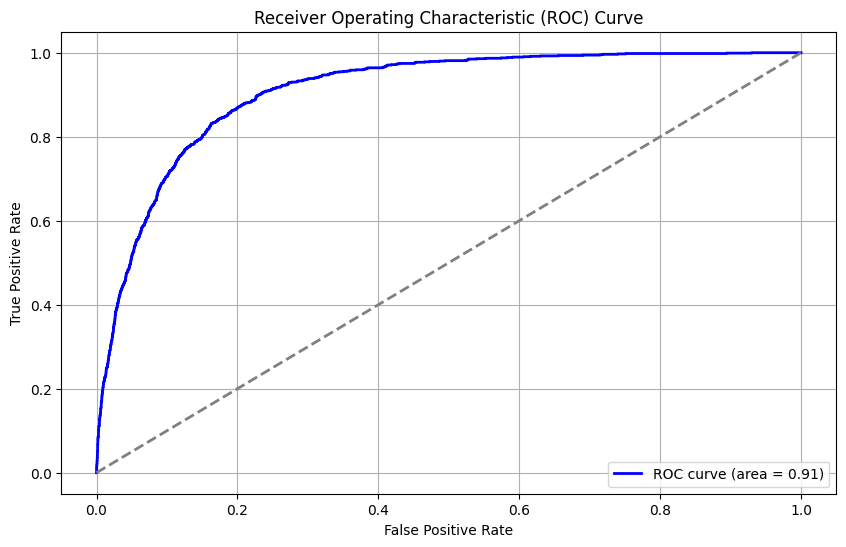

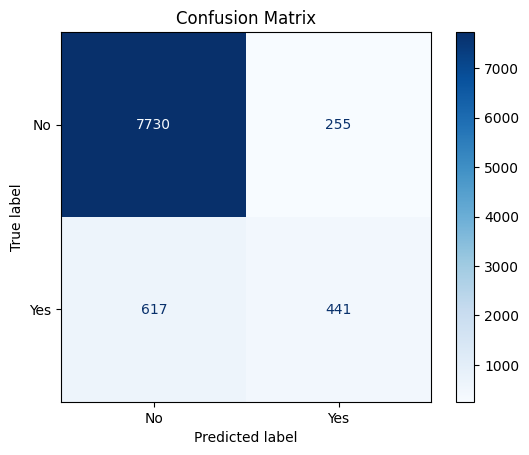

In [98]:
# Initialize the Gradient Boosting model with the optimized parameters from Randomized Search.
gb_model_random_optimized = GradientBoostingClassifier(**random_search_gb.best_params_, random_state=29)

# Fit the model and update the results table with evaluation metrics.
results_table = train_and_evaluate_model(gb_model_random_optimized, 
                                         X_train, X_test, y_train, y_test, 
                                         model_name='Gradient Boosting (Randomized Search)', 
                                         hyperparameters=str(random_search_gb.best_params_), 
                                         results_table=results_table)


In [99]:
# Add comments to Random Forest (Adjusted Threshold) model
results_table = update_comments(results_table, 'Gradient Boosting (Randomized Search)', 'The model tends to miss positive cases; it is advisable to optimize the threshold to improve the balance between Precision and Recall.')

**Analysis:**  

- The `F1 Score` is `0.50`, indicating a moderate level of balance between `Precision` and `Recall`. The model shows some improvement, but there is still room for further optimization.  
- The `ROC AUC` is `0.91`, which suggests an excellent ability of the model to distinguish between `Yes` and `No` classes. This means that the model performs well in recognizing positive and negative cases in terms of ranking probabilities.

**Confusion Matrix:**  

- **True Negatives (TN):** `7730` — correctly classified samples of the `No` class.  
- **False Positives (FP):** `255` — samples incorrectly classified as `Yes`, though they belong to the `No` class.  
- **False Negatives (FN):** `617` — samples incorrectly classified as `No`, though they belong to the `Yes` class.  
- **True Positives (TP):** `441` — correctly classified samples of the `Yes` class.  
- `False Positives (FP)` and `False Negatives (FN)` remain relatively high, with `FN` significantly exceeding `FP`. This indicates that the model is primarily prone to missing some positive cases.

**Conclusion:**  

- To further improve the results, it is worth adjusting the classification threshold. Threshold optimization could help balance `Precision` and `Recall`.


### Gradient Boosting (Randomized Search, Adjusted Threshold)

In [100]:
# Calculate probabilities for the positive class using the optimized Gradient Boosting model.
y_probs_gb = gb_model_random_optimized.predict_proba(X_test)[:, 1]

# Compute false positive rate, true positive rate, and thresholds using the ROC curve for Gradient Boosting.
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test, y_probs_gb)

# Calculate the Youden's index to find the optimal threshold for Gradient Boosting.
youden_index_gb = tpr_gb - fpr_gb
optimal_threshold_gb = thresholds_gb[np.argmax(youden_index_gb)]

# Print the optimal threshold value for the Gradient Boosting model.
print(f"Optimal threshold for Gradient Boosting: {round(optimal_threshold_gb, 2)}")


Optimal threshold for Gradient Boosting: 0.07


F1 Score (Test): 0.50
ROC AUC Score: 0.91


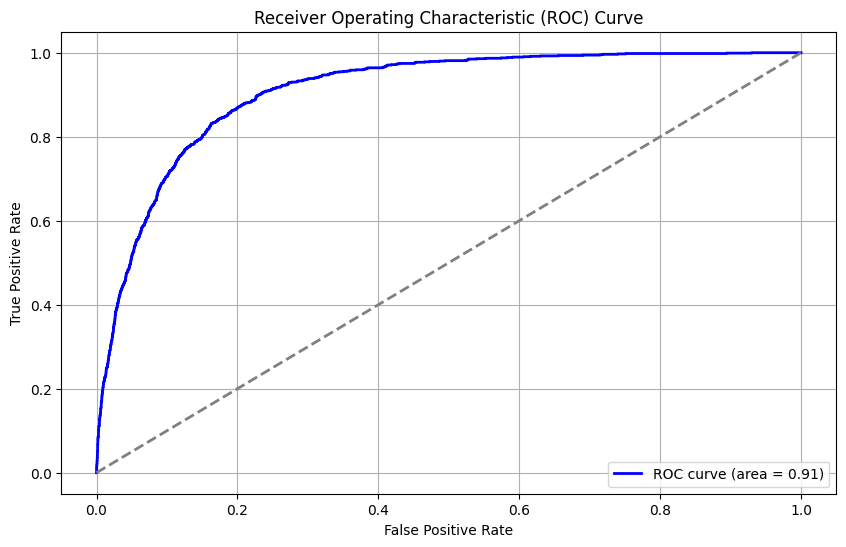

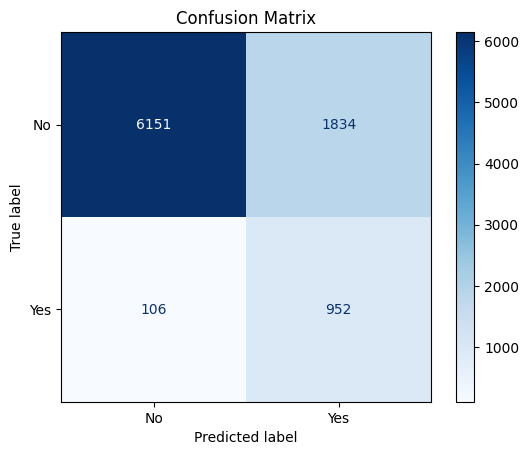

In [101]:
# Train and evaluate Gradient Boosting model with adjusted threshold
results_table = train_and_evaluate_model(gb_model_random_optimized, 
                                         X_train, X_test, y_train, y_test, 
                                         threshold=optimal_threshold_gb, 
                                         model_name='Gradient Boosting (Randomized Search, Adjusted Threshold)', 
                                         hyperparameters=str(random_search_gb.best_params_) + f', threshold={optimal_threshold_gb}', 
                                         results_table=results_table)

In [102]:
# Add comments to Random Forest (Adjusted Threshold) model
results_table = update_comments(results_table, 'Gradient Boosting (Randomized Search, Adjusted Threshold)', 'This model is better balanced; however, it is worth trying the Gradient Boosting model with Hyperopt (Bayesian Optimization) for further improvements.')

**Analysis:**  

- Lowering the threshold in the Gradient Boosting model significantly increases the number of positive predictions (`TP and FP`). This led to an increase in the `Recall` score due to more true positive cases, affecting the overall balance between `Precision` and `Recall`.  
- Reducing the threshold allowed for fewer missed positive cases (`FN`) at the cost of more incorrectly identified positive cases (`FP`), indicating a greater emphasis on maximizing `Recall`.  

**Conclusion:**  

- Overall, the model quality has not significantly improved. Between the two models, I would choose this one. However, it is worth trying the Gradient Boosting model with Hyperopt (Bayesian Optimization) for further improvements.  


### Gradient Boosting model with Hyperopt (Bayesian Optimization)

In [103]:
def objective(params: Dict[str, Any]) -> Dict[str, float]:
    """
    Objective function for hyperparameter optimization using Hyperopt.

    Parameters:
    params (Dict[str, Any]): Dictionary of hyperparameters for the Gradient Boosting model.

    Returns:
    Dict[str, float]: A dictionary containing the loss (negative F1 score) and status.
    """
    # Initialize and fit the Gradient Boosting model with the given parameters
    model = GradientBoostingClassifier(**params, random_state=29)
    model.fit(X_train, y_train)

    # Predict on the test set and calculate the F1 score
    y_pred = model.predict(X_test)
    f1: float = f1_score(y_test_np, y_pred, average='macro')

    # Return the negative F1 score as the loss (Hyperopt minimizes the loss)
    return {'loss': -f1, 'status': STATUS_OK}

In [104]:
# Define the parameter space for Hyperopt.
param_space = {
    'n_estimators': hp.choice('n_estimators', [50, 100, 200]),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'max_depth': hp.choice('max_depth', [3, 5, 7]),
    'min_samples_split': hp.choice('min_samples_split', [2, 5, 10]),
    'min_samples_leaf': hp.choice('min_samples_leaf', [1, 2, 4])
}

# Set up trials to record the optimization process.
trials = Trials()

# Run the optimization process for a maximum of 20 evaluations.
best_params = fmin(fn=objective, 
                   space=param_space, 
                   algo=tpe.suggest, 
                   max_evals=20, 
                   trials=trials, 
                   rstate=np.random.default_rng(29))

# Print the optimal hyperparameters found by Hyperopt.
print(f"Optimal hyperparameters for Gradient Boosting (Hyperopt): {best_params}")


100%|██████████| 20/20 [02:15<00:00,  6.78s/trial, best loss: -0.7222462684016822]
Optimal hyperparameters for Gradient Boosting (Hyperopt): {'learning_rate': 0.09276117355569657, 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1}


F1 Score (Test): 0.50
ROC AUC Score: 0.91


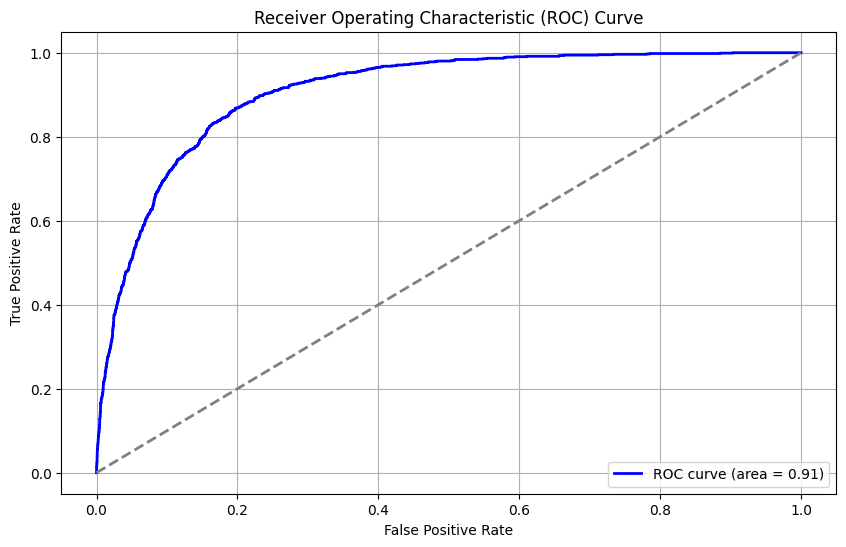

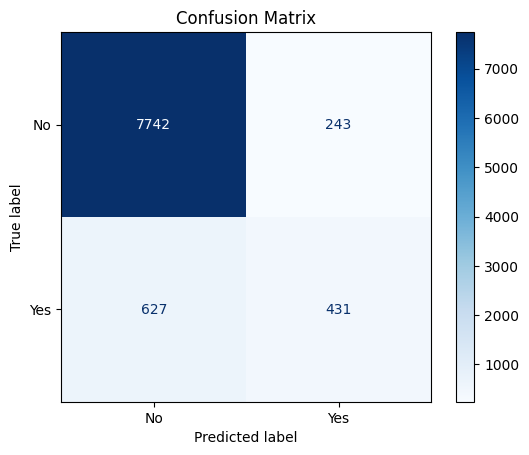

In [105]:
# Initialize the Gradient Boosting Classifier with optimized hyperparameters from Hyperopt
gb_model_hyperopt_optimized = GradientBoostingClassifier(
    n_estimators=[50, 100, 200][best_params['n_estimators']],  # Number of boosting stages
    learning_rate=best_params['learning_rate'],                  # Step size for each boosting step
    max_depth=[3, 5, 7][best_params['max_depth']],              # Maximum depth of individual trees
    min_samples_split=[2, 5, 10][best_params['min_samples_split']],  # Minimum samples to split an internal node
    min_samples_leaf=[1, 2, 4][best_params['min_samples_leaf']],      # Minimum samples at a leaf node
    random_state=29                                               # Seed for reproducibility
)

# Train and evaluate the model, storing results in the results_table
results_table = train_and_evaluate_model(gb_model_hyperopt_optimized, 
                                         X_train, X_test, y_train, y_test, 
                                         model_name='Gradient Boosting (Hyperopt)', 
                                         hyperparameters=str(best_params),  # Store hyperparameter information
                                         results_table=results_table)       # Update the results table with new results

In [106]:
# Add comments to Gradient Boosting (Hyperopt) model
results_table = update_comments(results_table, 'Gradient Boosting (Hyperopt)', 'The model effectively separates classes, but FN and FP remain problematic. After Bayesian optimization, the model is stable, but it is advisable to adjust the threshold to reduce errors.')

**Analysis:**  

- `F1 Score (Test): 0.50`  
- `ROC AUC Score: 0.91`  
- The `ROC curve` indicates high model quality with a large area under the curve of `0.91`. This suggests that the model has a good ability to distinguish between positive and negative classes.

**Confusion Matrix:**  

- `7742` correctly classified negative cases.  
- `431` correctly classified positive cases.  
- `243` incorrectly classified as positive (Type I errors).  
- `627` incorrectly classified as negative (Type II errors).

**Conclusion:**  

- The model demonstrates fairly good classification ability. After using `Bayesian hyperparameter optimization (Hyperopt)`, the model quality remained high, particularly regarding `ROC AUC`.

**Next Steps:**  

- Based on the confusion matrix, there is potential to improve the model by adjusting the threshold to reduce the number of errors.


In [107]:
# Calculate probabilities for the positive class using the optimized Gradient Boosting model from Hyperopt.
y_probs_gb_hyperopt = gb_model_hyperopt_optimized.predict_proba(X_test)[:, 1]

# Compute false positive rate, true positive rate, and thresholds using the ROC curve for Hyperopt Gradient Boosting.
fpr_gb_hyperopt, tpr_gb_hyperopt, thresholds_gb_hyperopt = roc_curve(y_test, y_probs_gb_hyperopt)

# Calculate the Youden's index to find the optimal threshold for the Gradient Boosting model optimized with Hyperopt.
youden_index_gb_hyperopt = tpr_gb_hyperopt - fpr_gb_hyperopt
optimal_threshold_gb_hyperopt = thresholds_gb_hyperopt[np.argmax(youden_index_gb_hyperopt)]

# Print the optimal threshold value for the Gradient Boosting model.
print(f"Optimal threshold for Gradient Boosting (Hyperopt): {round(optimal_threshold_gb_hyperopt, 3)}")


Optimal threshold for Gradient Boosting (Hyperopt): 0.097


F1 Score (Test): 0.52
ROC AUC Score: 0.91


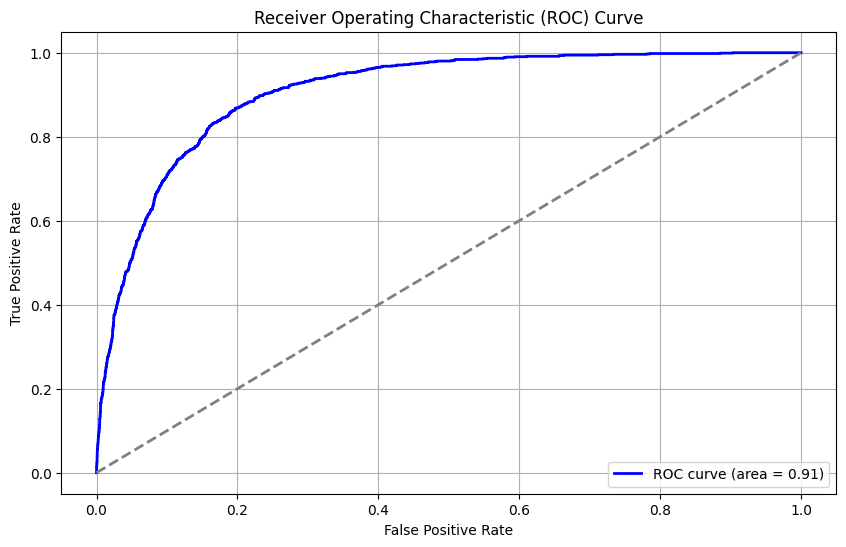

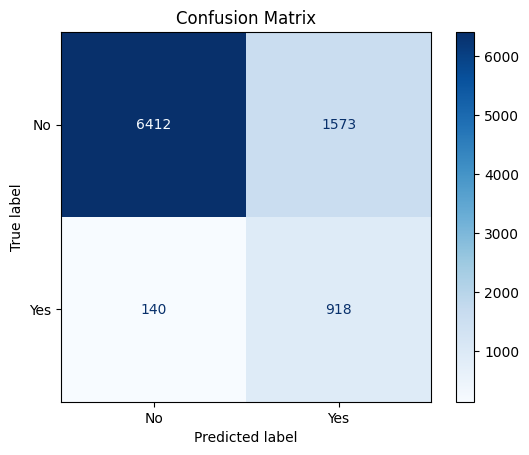

In [108]:
# Train and evaluate Gradient Boosting model with Hyperopt and adjusted threshold
results_table = train_and_evaluate_model(gb_model_hyperopt_optimized, 
                                         X_train, X_test, y_train, y_test, 
                                         threshold=optimal_threshold_gb_hyperopt, 
                                         model_name='Gradient Boosting (Hyperopt, Adjusted Threshold)', 
                                         hyperparameters=str(best_params) + f', threshold={optimal_threshold_gb_hyperopt}', 
                                         results_table=results_table)

In [109]:
# Add comments to Gradient Boosting (Hyperopt, Adjusted Threshold)
results_table = update_comments(results_table, 'Gradient Boosting (Hyperopt, Adjusted Threshold)', 'The model performs well with a high ROC AUC Score, but increased false positives indicate a need for retuning to balance Precision and Recall, potentially by reducing estimators or applying regularization.')

**Analysis:**  

- The `ROC AUC Score` for the model is `0.91`, which indicates a fairly high quality of classification between positive and negative classes. The ROC curve suggests that the model has good discrimination capability between classes.  
- The model successfully classified most cases of the `No` class (`6412`), though `1573` cases were incorrectly marked as `Yes`.  
- The model also correctly identified `918` cases of the `Yes` class, while `140` cases were incorrectly classified as `No`.  

**Conclusion:**  

- The `F1 Score` of `0.52` indicates some improvement compared to the initial model without threshold adjustment.  
- The model demonstrated high sensitivity, reducing the number of false negatives to `140`.  
- The increased number of false positives (`1573`) suggests an opportunity to retune the model for a better balance between `Precision` and `Recall`.

**Next Steps:**  

- It might be worth considering further reduction of the number of estimators (`n_estimators`) or applying more aggressive regularization to reduce model complexity.

In [110]:
results_table

,Model,Hyperparameters,F1 Score (Train),F1 Score (Test),ROC AUC Score,Threshold,Comments
0,Logistic Regression,"solver=liblinear, random_state=29",0.42,0.44,0.89,0.50,High ROC AUC but low F1: the model ranks well ...
1,Logistic Regression,"solver=liblinear, random_state=29",0.42,0.44,0.89,0.50,High ROC AUC but low F1: the model ranks well ...
2,Logistic Regression (Adjusted Threshold),"solver=liblinear, random_state=29, threshold=0...",0.42,0.48,0.89,0.08,Threshold optimization improved F1 from 0.44 t...
3,KNN (n_neighbors=3),n_neighbors=3,0.65,0.40,0.76,0.50,"After GridSearchCV, the optimal n_neighbors is..."
4,"KNN (Adjusted Threshold, n_neighbors=3)","n_neighbors=3, threshold=0.33",0.65,0.45,0.76,0.33,The optimal threshold for KNN is 0.33. F1 incr...
5,Decision Tree,random_state=29,1.00,0.40,0.66,0.50,"Firstly, the model is overfitting. It has limi..."
6,Decision Tree (Optimized),"{'max_depth': 10, 'min_samples_leaf': 4, 'min_...",0.57,0.49,0.87,0.50,Optimization improved F1 and ROC AUC. FP was r...
7,Decision Tree (Further Optimized),"{'max_depth': 5, 'min_samples_leaf': 2, 'min_s...",0.44,0.43,0.85,0.50,The model has become more sensitive to the neg...
8,Decision Tree (Optimized with Pruning),"{'max_depth': 10, 'min_samples_leaf': 4, 'min_...",0.51,0.51,0.84,0.50,The model with ccp_alpha pruning improved the ...
9,Decision Tree (Optimized with Pruning),"{'max_depth': 10, 'min_samples_leaf': 4, 'min_...",0.51,0.51,0.84,0.50,The model with ccp_alpha pruning improved the ...


**Table Analysis:**  
Based on the table, the best model is Gradient Boosting (Hyperopt, Adjusted Threshold) with the following metrics:

- **F1 Score (Test):** `0.52`
- **ROC AUC Score:** `0.91`
- **Threshold:** `0.10`

I will proceed with analyzing the feature importance for this model.


### Feature importances analysis

In [119]:
# Fit the best Gradient Boosting model to the training data.
best_model = gb_model_hyperopt_optimized
best_model.fit(X_train, y_train)

# Extract and sort the feature importances from the fitted model.
feature_importances = pd.Series(best_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Print the feature importances rounded to two decimal places.
print("Feature Importance:")
print(feature_importances.round(2))


Feature Importance:
duration             0.48
poutcome_success     0.22
age                  0.07
housing              0.04
contact_unknown      0.04
day                  0.04
balance              0.04
poutcome_unknown     0.02
campaign             0.01
loan                 0.01
marital_married      0.01
job_blue-collar      0.00
contact_telephone    0.00
poutcome_other       0.00
job_management       0.00
job_student          0.00
job_entrepreneur     0.00
job_housemaid        0.00
job_services         0.00
marital_single       0.00
job_technician       0.00
default              0.00
job_unemployed       0.00
job_self-employed    0.00
job_retired          0.00
job_unknown          0.00
previous             0.00
pdays                0.00
dtype: float64


**Feature Importance Analysis:**  
- Feature importance analysis indicates that the most significant variable is `duration`.

**Important Features:**
- **`duration (0.48)`**: This is the duration of the last phone call. Its high importance is logically justified, as longer calls are more likely to result in successful communication and subscription to a deposit.
- **`poutcome_success (0.22)`**: The previous success of a campaign is an important predictor. If a client successfully subscribed to a deposit previously, the likelihood of them subscribing again increases.
- **`age (0.07)`**: Age is also significant, as it can indicate stability and financial needs.

**Moderately Important Features:**
- **`housing (0.04)`**: Owning a house can indicate financial stability.
- **`contact_unknown (0.04)`**: The type of contact is important as it defines the communication channel with the client.
- **`balance (0.04)`**: The account balance influences the likelihood of subscribing to a deposit. Clients with a higher balance might have more financial capacity for deposits.

**Less Significant Features:**
- **`previous and pdays (0.00)`**: The zero importance of these features could be because they indicate the number of previous contacts, which may not always be a reliable predictor of success. However, from the previous EDA, they seemed significant.
- **`job`**: Job type. It is quite unexpected that job type is not important, as it often indicates financial stability.

**Conclusion:**
- Overall, the model's feature importance aligns logically with common sense. The most important features (`duration` and `poutcome_success`) indeed have a significant impact. However, some variables, such as `job` and `previous`, may have a greater impact in real life that is not reflected by the model, indicating potential limitations or the need for further analysis. It may be worth revisiting the impact of `job` and other socio-economic features. These features might need to be transformed or used in other models to verify their impact in combination with other factors.


### Analysis of Records Where the Model Makes Mistakes

In [120]:
# Analyze false positives and false negatives using the optimized Gradient Boosting model and the optimal threshold
best_model, optimal_threshold = gb_model_hyperopt_optimized, optimal_threshold_gb_hyperopt

# Predict probabilities and adjust predictions based on the optimal threshold
y_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= optimal_threshold).astype(int)

# Identify false positives and false negatives
false_positives = X_test[(y_test == 0) & (y_pred == 1)]
false_negatives = X_test[(y_test == 1) & (y_pred == 0)]

# Print the counts of false positives and false negatives
print(f"Number of False Positives: {false_positives.shape[0]}")
print(f"Number of False Negatives: {false_negatives.shape[0]}")


Number of False Positives: 1573
Number of False Negatives: 140


In [123]:
# Analyze false positives and false negatives by generating summary statistics
false_positives_summary = pd.DataFrame(false_positives).describe()
false_negatives_summary = pd.DataFrame(false_negatives).describe()

In [124]:
# Print the summary statistics for false positives
print("Analysis of False Positives:")
false_positives_summary.round(2)

Analysis of False Positives:


,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,job_technician,job_unemployed,job_unknown,marital_married,marital_single,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
count,1573.00,1573.00,1573.00,1573.00,1573.0,1573.00,1573.00,1573.00,1573.0,1573.0,...,1573.00,1573.00,1573.00,1573.00,1573.00,1573.00,1573.00,1573.00,1573.00,1573.00
mean,0.44,0.01,0.58,0.35,0.1,0.48,0.64,0.21,0.0,0.0,...,0.17,0.04,0.00,0.56,0.32,0.08,0.12,0.07,0.06,0.75
std,0.23,0.11,0.23,0.48,0.3,0.29,0.28,0.27,0.0,0.0,...,0.37,0.19,0.07,0.50,0.47,0.28,0.32,0.25,0.23,0.44
min,0.00,0.00,0.15,0.00,0.0,0.00,0.11,0.00,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.27,0.00,0.40,0.00,0.0,0.23,0.38,0.00,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.38,0.00,0.50,0.00,0.0,0.47,0.66,0.20,0.0,0.0,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
75%,0.59,0.00,0.72,1.00,0.0,0.70,0.93,0.20,0.0,0.0,...,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00
max,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00,0.0,0.0,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [125]:
# Print the summary statistics for false Negatives
print("Analysis of False Negatives:")
false_negatives_summary.round(2)

Analysis of False Negatives:


,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,job_technician,job_unemployed,job_unknown,marital_married,marital_single,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
count,140.00,140.0,140.00,140.00,140.00,140.00,140.00,140.00,140.0,140.0,...,140.00,140.00,140.00,140.00,140.00,140.00,140.00,140.00,140.00,140.00
mean,0.40,0.0,0.55,0.62,0.17,0.47,0.35,0.22,0.0,0.0,...,0.14,0.01,0.01,0.59,0.29,0.05,0.12,0.06,0.01,0.73
std,0.18,0.0,0.22,0.49,0.38,0.27,0.18,0.30,0.0,0.0,...,0.35,0.12,0.08,0.49,0.46,0.22,0.33,0.23,0.12,0.45
min,0.04,0.0,0.27,0.00,0.00,0.00,0.04,0.00,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.27,0.0,0.38,0.00,0.00,0.23,0.21,0.00,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.35,0.0,0.46,1.00,0.00,0.47,0.32,0.20,0.0,0.0,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
75%,0.54,0.0,0.68,1.00,0.00,0.64,0.47,0.40,0.0,0.0,...,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00
max,0.99,0.0,1.00,1.00,1.00,1.00,0.94,1.00,0.0,0.0,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


**Analysis of Results (False Positives and False Negatives):**

**False Positives — `1573` records:**
- **Average Age (`age`): 0.44** — Indicates relatively younger clients in this group.
- **Average Balance (`balance`): 0.58** — Suggests that the financial status of these clients is moderately high, which could have influenced the false positive classification.
- **Housing Loan (`housing`): 35%** — Have a housing loan, which is an average value for data standardized in the range of 0-1.
- **Loan (`loan`): 10%** — Only `10%` have a personal loan, which could indicate financial stability.

**Other Important Factors:**
- **Marital Status (`marital_married`): 56%** — Clients are married, indicating stability, which could have influenced their incorrect classification as positive cases.

**False Negatives (`140` records):**
- **Average Age (`age`): 0.40** — Slightly lower than that of false positives, indicating younger clients in this group.
- **Average Balance (`balance`): 0.55** — Lower compared to false positives, suggesting a slightly lower financial status.
- **Housing Loan (`housing`): 62%** — Have a housing loan, which is significantly higher compared to false positives. This suggests that clients with higher credit obligations may be incorrectly classified as not interested.
- **Loan (`loan`): 17%** — Have an additional loan, which might indicate higher financial obligations, possibly affecting their incorrect classification as negative cases.

**Other Important Factors:**
- **Marital Status (`marital_married`): 59%** — Clients are married, indicating stability, but other factors, such as high loan obligations, led to their incorrect negative classification.


**Conclusions and Recommendations:**

1. **Enhance the Importance of Call Duration (`duration`):**
   - Since call duration has the highest importance (`0.48`), special attention should be given to this parameter. Interaction duration is a strong indicator of customer interest; thus, further increasing the weight of this feature and analyzing its relationship with other features could be beneficial. Given that clients with longer call durations are more inclined to be interested, focusing more on these clients could reduce the number of false negatives.

2. **Focus on Previous Campaign Outcomes (`poutcome_success`):**
   - The success of previous campaigns has a weight of `0.22`, indicating its importance. Additional modeling based on this feature is recommended, particularly focusing on clients who successfully participated in previous campaigns. This could help reduce the number of false negatives.

3. **Reduce Weight of Financial Status:**
   - Features like balance (`balance`) and credit obligations (`housing` and `loan`) have low importance (`0.04 or lower`). The analysis of false positives shows that high financial stability often leads to incorrect positive predictions. Reducing the weight of financial features and increasing the weight of features that reflect direct customer interaction could help decrease the number of false positive predictions.

4. **Enhance the Importance of Client Interaction:**
   - The feature `contact_unknown` has an importance of `0.04`, indicating that unknown contacts can influence model outcomes. It is recommended to improve strategies for interacting with clients who have unknown contact information, such as making additional contact attempts or offering alternative communication channels. Adding features that evaluate other interaction channels (e.g., email, meetings) could significantly improve classification accuracy.

5. **Reevaluate Job Category and Marital Status Features:**
   - Features related to job categories (`job`) and marital status (`marital_married`) have zero or near-zero importance. The analysis showed that these features do not have a significant impact on customer classification, which could lead to the model being overloaded with irrelevant information. It is worth considering removing these features or significantly reducing their weight, which could decrease model complexity and improve efficiency.

6. **Regularization to Prevent Overfitting:**
   - Applying regularization (e.g., `L1` or `L2`) could help reduce the risk of overfitting, which may lead to classification errors. This will allow the model to generalize better and avoid excessive reliance on features with low importance, such as marital status or job categories.
